# Comp 47350 Homework2

## Introduction

This homework focuses on training and evaluating prediction models for a particular problem and dataset. The data comes from the Residential Property Price Register (RPPR) (https://www.propertypriceregister.ie/website/npsra/pprweb.nsf/page/ppr-home-en). The goal in this homework is to work with the data to build and evaluate prediction models that capture the relationship between the descriptive features and the target feature Price.

There are 5 parts for this homework.
1. Data Understanding and Preparation
2. Predictive Modeling and Evaluation: Linear Regression
3. Predictive Modeling and Evaluation: Decision Tree
4. Predictive Modeling and Evaluation: Random Forest
5. Improving Predictive Models

We will begin by importing the packages needed for this assignment. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from patsy import dmatrices

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import graphviz
from graphviz import Source
from graphviz import dot

# hide ipykernel warnings 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# 1) Data understanding and prep:

The original dataset has been cleaned in homework1 and is now imported as a starting point for this work. 
1. The accompanying data quality report from homework1 can be found attached as PDF as a background to this cleaned dataset;
2. A summary of this plan can be seen in the table below;
3. In addition a number of extra features were added (to to better capture the problem domain) that were not in the original dataset.

### Summary of data quality plan:

| Variable Names                     | Data Quality Issue            | Handling Strategy               |
|------------------------------------|-------------------------------|---------------------------------|
| DateofSales(dd/mm/yyyy)            | Some dates failed the tests.  | Update the incorrect date.      |
| Address                            | High cardinalities.           | Keep as is.                     |
| PostalCode                         | Missing values(80.67%)        | Extract postal code from 'Address' column, or refill by 'N/A'.|
| PostalCode                         | Some instances failed the tests.| Remove the incorrect postal code information.|
| County                             | None.                         | Keep as is.                     |
| Price(€)                           | Outliers.                     | Remove the outliers.            |
| NotFullMarketPrice                 | None.                         | Keep as is.                     |
| VATExclusive                       | Some instances failed the tests.| Update the incorrect information.|
| DescriptionofProperty              | None.                         | Keep as is.                     |
| PropertySizeDescription            | Categories overlap.           | Combine the overlapped categories.|
| PropertySizeDescription            | Missing values(89.45%)        | Keep as is.                     |

First of all, we import the dataset we have from homework1.

In [2]:
#read the cleaned csv.
df = pd.read_csv("prr_21200066_new_features.csv")

### Preliminary Checks and Preperation

Before going any further we will now perform some data preliminary checks and preperation on the dataset which we have just imported.

In [3]:
#check the shape of the dataset
df.shape

(9454, 14)

In [4]:
#check the first five lines and last five lines of the dataset.
df.head(5)

,DateofSale(dd/mm/yyyy),Address,PostalCode,County,Price(€),NotFullMarketPrice,VATExclusive,DescriptionofProperty,PropertySizeDescription,percent,VAT,Year,Month,Agent Commission
0,2013-09-20,"I Cabbage Lane, Bohermore",NaN,Galway,235000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,0.012695,31725.00,2013,9,3525.00
1,2014-06-25,"CLONEEN, CRETTYARD, VIA CARLOW",NaN,Kilkenny,63000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,0.012695,8505.00,2014,6,945.00
2,2017-02-10,"22 COILLIN BUI, MOATE, WESTMEATH",NaN,Westmeath,95250.0,Yes,No,Second-Hand Dwelling house /Apartment,NaN,0.012695,12858.75,2017,2,1428.75
3,2018-07-06,"No. 1 Larch Close, Bloomfield, Annacotty",NaN,Limerick,233480.0,No,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,0.063412,0.00,2018,7,3502.20
4,2015-10-16,"2 THE CLOSE, DUN EALA, FERMOY",NaN,Cork,110000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,0.012695,14850.00,2015,10,1650.00


In [5]:
#check the first five lines and last five lines of the dataset.
df.tail(5)

,DateofSale(dd/mm/yyyy),Address,PostalCode,County,Price(€),NotFullMarketPrice,VATExclusive,DescriptionofProperty,PropertySizeDescription,percent,VAT,Year,Month,Agent Commission
9449,2021-11-01,"1 SANDFIELD TERRACE, MALLOW, CORK",NaN,Cork,150000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,0.012695,20250.0,2021,11,2250.0
9450,2021-03-11,"APT 4 RAILWAY VIEW HOUSE, HULK STREET, CLIFDEN",NaN,Galway,79000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,0.012695,10665.0,2021,3,1185.0
9451,2014-12-15,"12 HANOVER QUARTER, HANOVER QUAY,,Dublin 2",Dublin 2,Dublin,460000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,0.012695,62100.0,2014,12,6900.0
9452,2016-09-15,"32 Landen Park, Oldtown Demesne, Naas",NaN,Kildare,317180.0,No,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,0.063412,0.0,2016,9,4757.7
9453,2021-01-29,"65 LAUREL GROVE, TAGOAT, WEXFORD",NaN,Wexford,155000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,0.012695,20925.0,2021,1,2325.0


We will drop the column 'percent' in the dataset.

In [6]:
#Drop the column 'percent'
df = df.drop("percent",1)

Also, we will drop the column 'VAT' since this newly-created feature is dependent on the 'VATExclusive' and 'Price', and couldn't bring any additional information.

In [7]:
#Drop the column 'VAT'
df = df.drop("VAT",1)

Also, we will drop 'DateofSale(dd/mm/yyyy)' as is duplicated with column 'Year' and 'Month'

In [8]:
#Drop the DateofSale(dd/mm/yyyy)
df = df.drop("DateofSale(dd/mm/yyyy)", 1)

Now we will convert the datatype into proper types.

In [9]:
df.dtypes

Address                     object
PostalCode                  object
County                      object
Price(€)                   float64
NotFullMarketPrice          object
VATExclusive                object
DescriptionofProperty       object
PropertySizeDescription     object
Year                         int64
Month                        int64
Agent Commission           float64
dtype: object

In [10]:
#Convert the data into proper type
object_columns = df.select_dtypes(['object']).columns
for column in object_columns:
    df[column] = df[column].astype('category')

In [11]:
df.dtypes

Address                    category
PostalCode                 category
County                     category
Price(€)                    float64
NotFullMarketPrice         category
VATExclusive               category
DescriptionofProperty      category
PropertySizeDescription    category
Year                          int64
Month                         int64
Agent Commission            float64
dtype: object

For the feature 'Address', we will convert all addresses to small caps, such as 'Street' and 'Town', to reduce the cardinality.

In [12]:
df[["Address","Town"]] = df['Address'].str.rsplit(',', 1, expand=True)

In [13]:
df["Town"] = df["Town"].str.lower()
df["Town"] = df["Town"].str.title()
df["Address"] = df["Address"].str.lower()
df["Address"] = df["Address"].str.title()

In [14]:
df = df.rename(columns={"Address":"Street"})

Now we will check the cardinality of 'Street' and 'Town'

In [15]:
# Check for irregular cardinality & permitted values
print("Street:", pd.unique(df["Street"].ravel()))
print("Town:", pd.unique(df["Town"].ravel()))

Street: ['I Cabbage Lane' 'Cloneen, Crettyard' '22 Coillin Bui, Moate' ...
 '12 Hanover Quarter, Hanover Quay,' '32 Landen Park, Oldtown Demesne'
 '65 Laurel Grove, Tagoat']
Town: [' Bohermore' ' Via Carlow' ' Westmeath' ... ' Goleen' ' Mountrath Rd'
 ' South Brown Street']


Now, we will drop rows where 'NotFullMarketPrice == yes', as this is considered to be inaccurate representation of true property value.

In [16]:
#Filt out the NotFullMarketPrice rows
df_NotFullMarketPrice = df[df["NotFullMarketPrice"]== "Yes"]

In [17]:
#Drop the rows
df = df.drop(df_NotFullMarketPrice.index)

Once rows are dropped, 'NotFullMarketPrice' will become a constant column and the feature will be dropped

In [18]:
#Drop the column NotFullMarketPrice
df = df.drop("NotFullMarketPrice",1)

In [19]:
df.shape

(8983, 11)

In the following cells, we will add 13.5% VAT to all VAT exclusive properties to make prices comparable.

In [20]:
for i in range(len(df["Price(€)"])):
    if df.iloc[i]["VATExclusive"]== "Yes":
        df.iloc[[i],[df.columns.get_loc("Price(€)")]] = (float(df.iloc[i]["Price(€)"])*1.135)

df["Price(€)"] = df["Price(€)"].astype('float64')

In [21]:
df[df["VATExclusive"]== "Yes"]

,Street,PostalCode,County,Price(€),VATExclusive,DescriptionofProperty,PropertySizeDescription,Year,Month,Agent Commission,Town
3,"No. 1 Larch Close, Bloomfield",NaN,Limerick,264999.8000,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,2018,7,3502.2000,Annacotty
9,"5 The Green, Castle Farm",NaN,Kildare,330000.0015,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,2018,12,4361.2335,Naas
23,"86 Millquarter, Knockmullen",NaN,Wexford,329150.0000,Yes,New Dwelling house /Apartment,NaN,2019,9,4350.0000,Gorey
24,"Carrowreagh, Elphin",NaN,Roscommon,278075.0000,Yes,New Dwelling house /Apartment,NaN,2021,12,3675.0000,Castlerea
26,26 Ard Na Greine,NaN,Cork,249999.6400,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,2013,10,3303.9600,Bantry
...,...,...,...,...,...,...,...,...,...,...,...
9421,299 Beechwood Court,NaN,Dublin,304553.4150,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,2015,4,4024.9350,Stillorgan Road
9422,"Rosewood, Castletaylor North",NaN,Galway,300165.2780,Yes,New Dwelling house /Apartment,greater than or equal to 125 sq metres,2010,7,3966.9420,Kilcolgan
9436,"22 Abbey Gardens, Abbeyside",NaN,Waterford,334999.7900,Yes,New Dwelling house /Apartment,NaN,2020,2,4427.3100,Dungarvan
9443,"6 The Village Green, The Spa",NaN,Kerry,419346.1800,Yes,New Dwelling house /Apartment,greater than or equal to 125 sq metres,2015,4,5542.0200,Tralee


After adding VAT back into the price, we can drop the column 'VATExclusive'

In [22]:
#Drop VATExclusive
df = df.drop("VATExclusive", 1)

In [23]:
#Change the name from "Price(€)" into "PriceVatInclusive(€)"
df = df.rename(columns={"Price(€)":"PriceVatInclusive(€)"})

In [24]:
#Check first 10 rows.
df.head(10)

,Street,PostalCode,County,PriceVatInclusive(€),DescriptionofProperty,PropertySizeDescription,Year,Month,Agent Commission,Town
0,I Cabbage Lane,NaN,Galway,235000.0000,Second-Hand Dwelling house /Apartment,NaN,2013,9,3525.0000,Bohermore
1,"Cloneen, Crettyard",NaN,Kilkenny,63000.0000,Second-Hand Dwelling house /Apartment,NaN,2014,6,945.0000,Via Carlow
3,"No. 1 Larch Close, Bloomfield",NaN,Limerick,264999.8000,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,2018,7,3502.2000,Annacotty
4,"2 The Close, Dun Eala",NaN,Cork,110000.0000,Second-Hand Dwelling house /Apartment,NaN,2015,10,1650.0000,Fermoy
6,"Apt 3 Clonard Court, Poddel Park, Kimmage",Dublin 12,Dublin,240000.0000,Second-Hand Dwelling house /Apartment,NaN,2020,6,3600.0000,Dublin 12
7,"10 The Moorings, Kellys Bay",Dublin 20,Dublin,185000.0000,Second-Hand Dwelling house /Apartment,NaN,2016,5,2775.0000,Skerries
8,23 Stephen St,NaN,Kilkenny,182500.0000,Second-Hand Dwelling house /Apartment,NaN,2018,11,2737.5000,Kilkenny
9,"5 The Green, Castle Farm",NaN,Kildare,330000.0015,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,2018,12,4361.2335,Naas
10,"Porres, Linaro Ave",NaN,Cork,270000.0000,Second-Hand Dwelling house /Apartment,NaN,2015,8,4050.0000,Magazine Rd
11,Gortacrissane,NaN,Kerry,245000.0000,Second-Hand Dwelling house /Apartment,NaN,2010,6,3675.0000,Listowel


Here we will rearrange the order of the columns.

In [25]:
df = df.reindex(columns=['Year','Month', 'Street','Town','County','PostalCode','PriceVatInclusive(€)','DescriptionofProperty','PropertySizeDescription','Agent Commission'])

In the following cell, we will fill in the empty columns of 'PostalCode' and 'PropertySizeDescription' with String value 'N/A'

In [26]:
#Convert the datatype into 'object'.
date_columns = ['PostalCode','PropertySizeDescription']
for column in date_columns:
    df[column] = df[column].astype('object')    
df.dtypes

df['PostalCode'].fillna('N/A', inplace=True)
df['PropertySizeDescription'].fillna('N/A', inplace=True)

In [27]:
df.isna().sum()

Year                       0
Month                      0
Street                     0
Town                       0
County                     0
PostalCode                 0
PriceVatInclusive(€)       0
DescriptionofProperty      0
PropertySizeDescription    0
Agent Commission           0
dtype: int64

In the following cellings, we will introduced two new features from external data sources which are considered to affect the price of property. From the research https://www.investopedia.com/articles/mortages-real-estate/11/factors-affecting-real-estate-market.asp, we know that macro-economic figures can be the factores that drive the real estate market. Therefore, we select Highest Mortgage Interest Rate and GDP as new features for predicting house price.

Data of Highest Mortgage Interest Rate come from: https://www.moneyguideireland.com/history-of-mortgage-rates-in-ireland.html

In [28]:
df["HighestMortgageInterestRate"] = 0
df["HighestMortgageInterestRate"][df["Year"] == 2010] = 0.0402
df["HighestMortgageInterestRate"][df["Year"] == 2011] = 0.0442
df["HighestMortgageInterestRate"][df["Year"] == 2012] = 0.0433
df["HighestMortgageInterestRate"][df["Year"] == 2013] = 0.0438
df["HighestMortgageInterestRate"][df["Year"] == 2014] = 0.0420
df["HighestMortgageInterestRate"][df["Year"] == 2015] = 0.0405
df["HighestMortgageInterestRate"][df["Year"] == 2016] = 0.0361
df["HighestMortgageInterestRate"][df["Year"] == 2017] = 0.0344
df["HighestMortgageInterestRate"][df["Year"] == 2018] = 0.0321
df["HighestMortgageInterestRate"][df["Year"] == 2019] = 0.0302
df["HighestMortgageInterestRate"][df["Year"] == 2020] = 0.0292
df["HighestMortgageInterestRate"][df["Year"] == 2021] = 0.0280
df["HighestMortgageInterestRate"][df["Year"] == 2022] = 0.0280

Data of GDP come from: https://www.macrotrends.net/countries/IRL/ireland/gdp-gross-domestic-product

In [29]:
#2022 GDP not yet available, replace by 2021 GDP

In [30]:
df["GDP($ Billions)"] = 0
df["GDP($ Billions)"][df["Year"] == 2010] = 222.29
df["GDP($ Billions)"][df["Year"] == 2011] = 237.96
df["GDP($ Billions)"][df["Year"] == 2012] = 224.97
df["GDP($ Billions)"][df["Year"] == 2013] = 238.55
df["GDP($ Billions)"][df["Year"] == 2014] = 259.25
df["GDP($ Billions)"][df["Year"] == 2015] = 291.64
df["GDP($ Billions)"][df["Year"] == 2016] = 299.76
df["GDP($ Billions)"][df["Year"] == 2017] = 339.34
df["GDP($ Billions)"][df["Year"] == 2018] = 386.16
df["GDP($ Billions)"][df["Year"] == 2019] = 398.59
df["GDP($ Billions)"][df["Year"] == 2020] = 418.62
df["GDP($ Billions)"][df["Year"] == 2021] = 440.00
df["GDP($ Billions)"][df["Year"] == 2022] = 440.00

Now we will reset the index number.

In [31]:
#Reset the index number.
df.reset_index(drop=True, inplace=True)

In [32]:
df.head(5)

,Year,Month,Street,Town,County,PostalCode,PriceVatInclusive(€),DescriptionofProperty,PropertySizeDescription,Agent Commission,HighestMortgageInterestRate,GDP($ Billions)
0,2013,9,I Cabbage Lane,Bohermore,Galway,N/A,235000.0,Second-Hand Dwelling house /Apartment,N/A,3525.0,0.0438,238.55
1,2014,6,"Cloneen, Crettyard",Via Carlow,Kilkenny,N/A,63000.0,Second-Hand Dwelling house /Apartment,N/A,945.0,0.0420,259.25
2,2018,7,"No. 1 Larch Close, Bloomfield",Annacotty,Limerick,N/A,264999.8,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,3502.2,0.0321,386.16
3,2015,10,"2 The Close, Dun Eala",Fermoy,Cork,N/A,110000.0,Second-Hand Dwelling house /Apartment,N/A,1650.0,0.0405,291.64
4,2020,6,"Apt 3 Clonard Court, Poddel Park, Kimmage",Dublin 12,Dublin,Dublin 12,240000.0,Second-Hand Dwelling house /Apartment,N/A,3600.0,0.0292,418.62


In [33]:
df.tail(5)

,Year,Month,Street,Town,County,PostalCode,PriceVatInclusive(€),DescriptionofProperty,PropertySizeDescription,Agent Commission,HighestMortgageInterestRate,GDP($ Billions)
8978,2021,11,"1 Sandfield Terrace, Mallow",Cork,Cork,N/A,150000.0,Second-Hand Dwelling house /Apartment,N/A,2250.0,0.0280,440.00
8979,2021,3,"Apt 4 Railway View House, Hulk Street",Clifden,Galway,N/A,79000.0,Second-Hand Dwelling house /Apartment,N/A,1185.0,0.0280,440.00
8980,2014,12,"12 Hanover Quarter, Hanover Quay,",Dublin 2,Dublin,Dublin 2,460000.0,Second-Hand Dwelling house /Apartment,N/A,6900.0,0.0420,259.25
8981,2016,9,"32 Landen Park, Oldtown Demesne",Naas,Kildare,N/A,359999.3,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,4757.7,0.0361,299.76
8982,2021,1,"65 Laurel Grove, Tagoat",Wexford,Wexford,N/A,155000.0,Second-Hand Dwelling house /Apartment,N/A,2325.0,0.0280,440.00


In [34]:
df.dtypes

Year                              int64
Month                             int64
Street                           object
Town                             object
County                         category
PostalCode                       object
PriceVatInclusive(€)            float64
DescriptionofProperty          category
PropertySizeDescription          object
Agent Commission                float64
HighestMortgageInterestRate     float64
GDP($ Billions)                 float64
dtype: object

We will now setup our categorical and continuous features. These will be needed for plotting and for the creation of dummies later.

In [35]:
categorical_features = df.select_dtypes(['category']).columns
continuous_features = ['Year', 'Month','Agent Commission','HighestMortgageInterestRate','GDP($ Billions)']

## 1.1 Randomly shuffle the rows of your dataset and split the dataset into two datasets: 70% training and 30% test. Keep the test set aside. 

In [36]:
# randomly generate sequence based on dataframe index and set to be new index
df.set_index(np.random.permutation(df.index))
# sort the resulting random index
df.sort_index(inplace=True)
df.head(5)

,Year,Month,Street,Town,County,PostalCode,PriceVatInclusive(€),DescriptionofProperty,PropertySizeDescription,Agent Commission,HighestMortgageInterestRate,GDP($ Billions)
0,2013,9,I Cabbage Lane,Bohermore,Galway,N/A,235000.0,Second-Hand Dwelling house /Apartment,N/A,3525.0,0.0438,238.55
1,2014,6,"Cloneen, Crettyard",Via Carlow,Kilkenny,N/A,63000.0,Second-Hand Dwelling house /Apartment,N/A,945.0,0.0420,259.25
2,2018,7,"No. 1 Larch Close, Bloomfield",Annacotty,Limerick,N/A,264999.8,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,3502.2,0.0321,386.16
3,2015,10,"2 The Close, Dun Eala",Fermoy,Cork,N/A,110000.0,Second-Hand Dwelling house /Apartment,N/A,1650.0,0.0405,291.64
4,2020,6,"Apt 3 Clonard Court, Poddel Park, Kimmage",Dublin 12,Dublin,Dublin 12,240000.0,Second-Hand Dwelling house /Apartment,N/A,3600.0,0.0292,418.62


##### The dataset will now be split into two datasets: 70% training and 30% test
- First we will set the target feature "y" to "PriceVatInclusive(€)"
- Then we will set "X" to be the remaining features in the dataframe.

In [37]:
# y = df.binary_outcome
y = pd.DataFrame(df["PriceVatInclusive(€)"])
X = df.drop(["PriceVatInclusive(€)"],1)

##### The data set can now be split
- The train test split will randomly split the dataset as per the test size
- We will set the random state=1 to allow the random shuffle to be repeated within this notebook only

In [38]:
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)

print("original range is: ",df.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  8983
training range (70%):	 rows 0 to 6288
test range (30%): 	 rows 6288 to 8983


The dataset is now ready for plotting

## 1.2 On the training set we will now carry out a series of plots comparing all features to help make decisions on what features to keep for the model 

- All plots will be using the training subset of dataset: X_train, y_train

### 1.2.1 Plot the correlations between all the continuous features. 

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'Year'),
  Text(1.5, 0, 'Month'),
  Text(2.5, 0, 'Agent Commission'),
  Text(3.5, 0, 'HighestMortgageInterestRate'),
  Text(4.5, 0, 'GDP($ Billions)')])

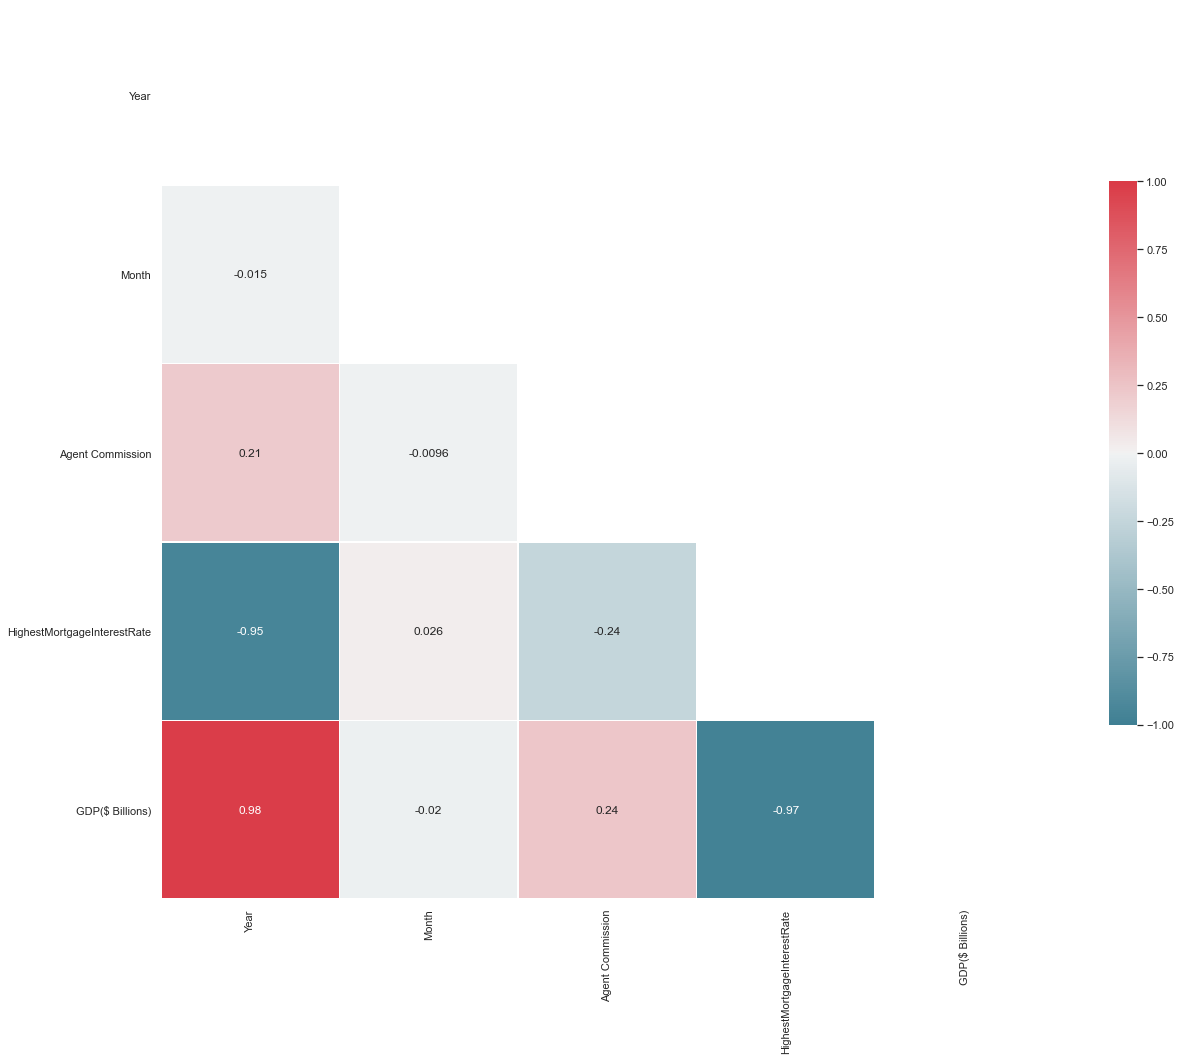

In [39]:
# Correlation matrix using code found on https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
sns.set(style="white")

# Calculate correlation of all pairs of continuous features
corr = X_train[continuous_features].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom colormap - blue and red
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)

#### Interpretation of the results
-  *Year* and *GDP* have a high correlation of 0.98. This is an expected and indicates that GDP of Ireland grows every year.
-  *Year* and *HighestMortgageInterestRate* have a high negative correlation of -0.95, this is because the mortgage interest rates have been falling since 2010.
-  *Year* and *Agent Commission* have a quite low correlation of 0.21, this is because the Agent Commission is calculated based on the price of the property. However, the price rises generally over years, which causes an increase of Agent Commission fee. So that might explain the reason why the correlation is 0.21
-  'Month' have low correlation with all the other continuous features, we will check this feature against the target later and if no strong correlation we can remove then


### 1.2.2 Plot interaction between continuous features and target feature
- Here we will loop over each continuous feature and make a scatter plot against the target 'PriceVatInclusive(€)'
- We will discuss what we observe from these plots, e.g. which continuous features seem to be better at predicting the target feature
- We will choose a subset of continuous features we find promising (if any) and justify our choice.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,PriceVatInclusive(€)
Agent Commission,0.988850
GDP($ Billions),0.229405
Year,0.206623
Month,-0.007798
HighestMortgageInterestRate,-0.236282


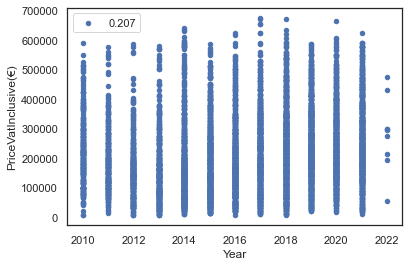

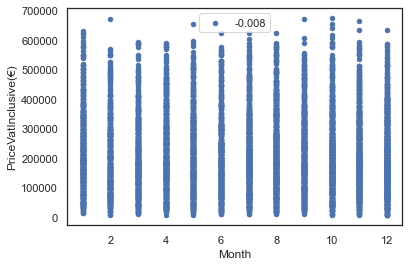

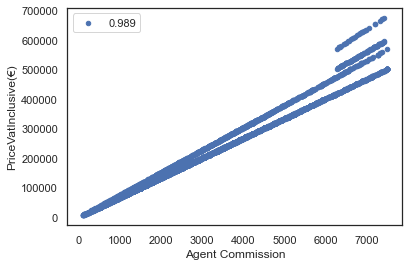

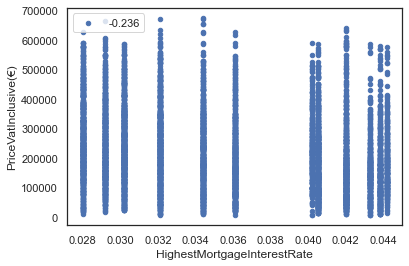

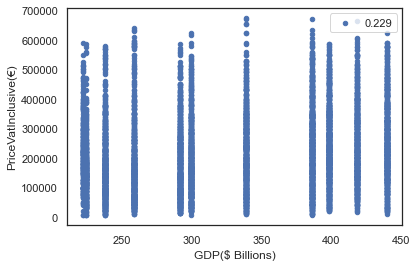

In [40]:
# dict to hold correlation values 
corr_dict = {}

# plot pairwise interaction between all continuous features and target
for column in X_train[continuous_features]:
    # create temp df to merge column and target
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    # store correlation in variable
    correlation = df_temp[[column, "PriceVatInclusive(€)"]].corr().values[0,1]
    # plot the column and tartget feature
    df_temp.plot(kind='scatter', x=column, y="PriceVatInclusive(€)", label="%.3f" % correlation)
    # add correlation to dict
    corr_dict[column] = correlation

# dataframe holding sorted correlation values to aid in interpreting results
corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['PriceVatInclusive(€)']).sort_values('PriceVatInclusive(€)', ascending=False)
corr_df

#### Interpretation of the results

As we can see from the table and graphs above:
- Most of the continuous features have week correlation with the target feature, except *Agent Commission*.
- The feature *Year* is expected to have an strong effect on the target feature as it is believed that the price of property increases over years. However, the correlation is 0.207.
- The feature *GDP* and *HighestMortgageInterestRate* have similar correlation between the target feature, 0.229 and -0.236 respectively, which are close to the correlation that *Year* has.
- The feature *Agent Commission* has extremely strong correlation with target feature, which is 0.989. This is expected as we explained above, the *Agent Commission* is the new featured calculated by the price multiplying a certain percentage of agent fee. We will drop this feature because data in this feature is not the data obtained from real statistics, but by estimation. So it is not helpful for the training of the model and will be dropped before the data training.
- The correlation between *Month* and the outcome is -0.008. This feature will be dropped as these results show that it is likely not an indicator of the outcome. 

For now we will label the two continuous features as ```low_correlation_continuous_features``` and will remove them after analysing the categorical features. 

In [41]:
low_correlation_continuous_features = ['Month', 'Agent Commission']

### 1.2.3 Plot interaction between categorical features and target feature.

- We will now plot a pairwise interaction between each categorical feature and the target feature. 
- We will discuss which features seem to be better at predicting the target feature and will choose a subset of features we find promising.
- As with the plots of continuous features above, only the training dataset will be used. 
- To create these plots we will work with the variable *categorical_features* created above. 
- We will begin by converting the target feature to a categorical type as this is required for these plots. 

In [42]:
# for the comparison we will convert the target back to categorical
y_train = y_train.astype("category")

Here we will create temp dataframe for plotting.

In [43]:
# we will create temp dataframe for these plots, mergeing X_train and y_train
df_temp= pd.concat([X_train, y_train], axis=1)

In [44]:
df_temp

,Year,Month,Street,Town,County,PostalCode,DescriptionofProperty,PropertySizeDescription,Agent Commission,HighestMortgageInterestRate,GDP($ Billions),PriceVatInclusive(€)
7602,2016,12,"9 The Avenue, Rathdale",Enfield,Meath,N/A,Second-Hand Dwelling house /Apartment,N/A,3150.000,0.0361,299.76,210000.000
4192,2014,3,"17 Castleoaks, Castle Rd",Bandon,Cork,N/A,Second-Hand Dwelling house /Apartment,N/A,1800.000,0.0420,259.25,120000.000
4485,2016,11,"Kilronan, Inis Mor",Aran Islands,Galway,N/A,Second-Hand Dwelling house /Apartment,N/A,1537.500,0.0361,299.76,102500.000
4741,2016,7,"25 Ashleigh Wood, Monaleen",Castletroy,Limerick,N/A,Second-Hand Dwelling house /Apartment,N/A,6450.000,0.0361,299.76,430000.000
2537,2016,4,19 Maydenhayes Lane,Mornington,Meath,N/A,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,3422.895,0.0361,299.76,258999.055
...,...,...,...,...,...,...,...,...,...,...,...,...
2895,2015,2,"141 Clonmacnoise Rd, Crumlin,",Dublin 12,Dublin,Dublin 12,Second-Hand Dwelling house /Apartment,N/A,1200.000,0.0405,291.64,80000.000
7813,2010,4,13 Mccabe Villas,Booterstown,Dublin,N/A,Second-Hand Dwelling house /Apartment,N/A,3300.000,0.0402,222.29,220000.000
905,2021,7,"14 Est Ave, Merrion Rd, Ballsbridge",Dublin 4,Dublin,Dublin 4,Second-Hand Dwelling house /Apartment,N/A,6812.500,0.0280,440.00,545000.000
5192,2011,7,"83 Marian Place, Tullamore",Offaly,Offaly,N/A,Second-Hand Dwelling house /Apartment,N/A,1500.000,0.0442,237.96,100000.000


#### Town VS PriceVatInclusive(€)

<AxesSubplot:title={'center':'PriceVatInclusive(€)'}, xlabel='[Town]'>

<Figure size 432x288 with 0 Axes>

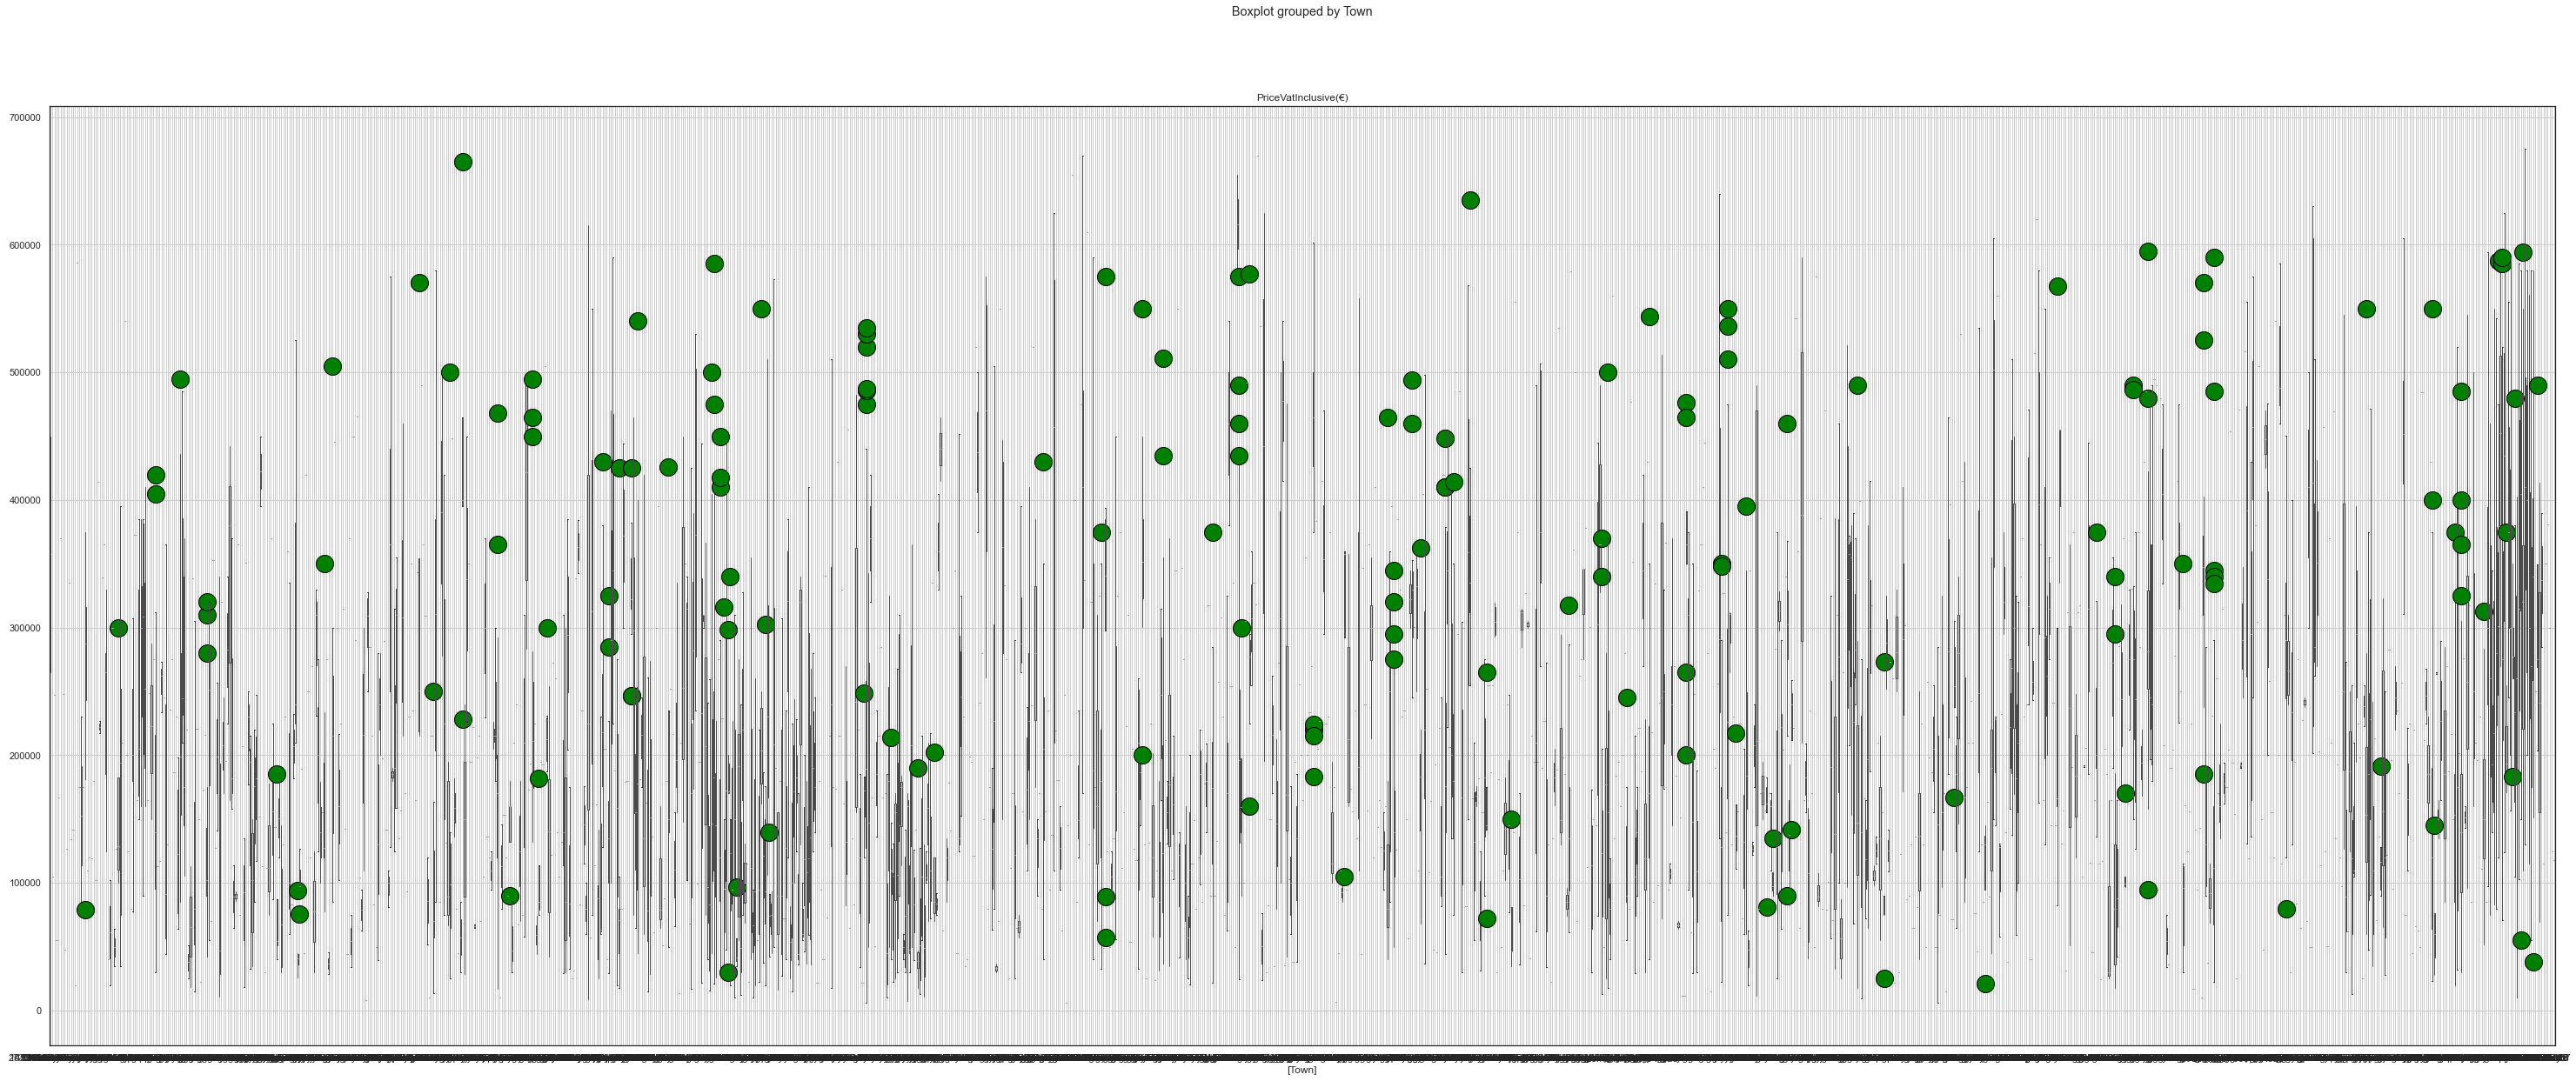

In [45]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=20, 
                  linestyle='none')
df_temp.boxplot(column=['PriceVatInclusive(€)'], by=['Town'], flierprops=flierprops, figsize=(50,20))

In [46]:
#select the categories with top 5 frequency of instances
histograms_plot = df_temp['Town'].value_counts().nlargest(5).index
list_for_index = []
for i in histograms_plot:
    list_for_index.append(i)

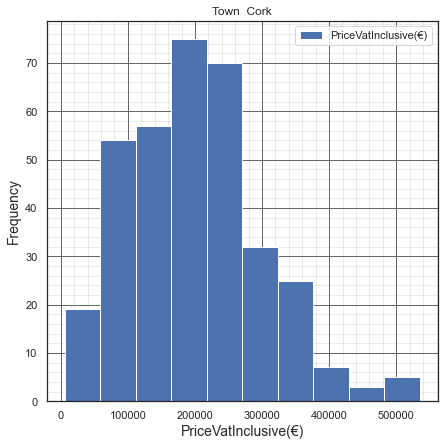

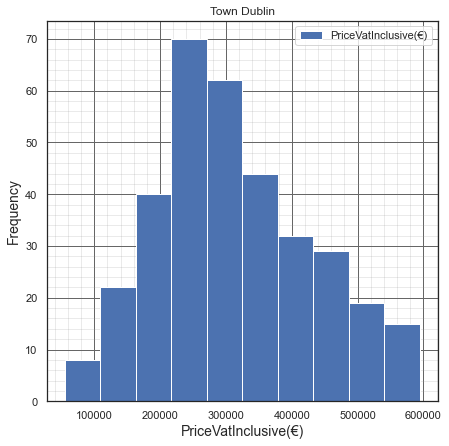

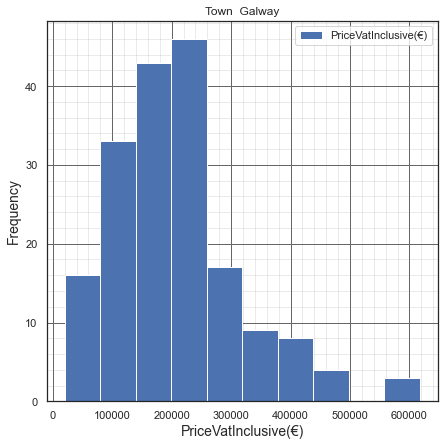

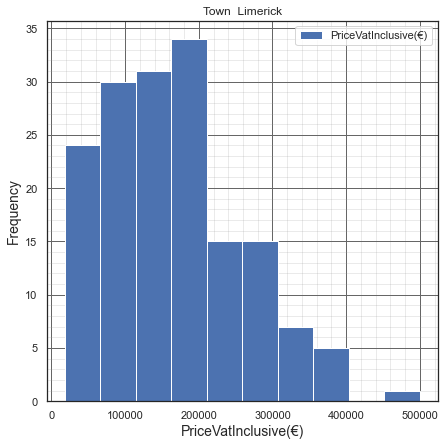

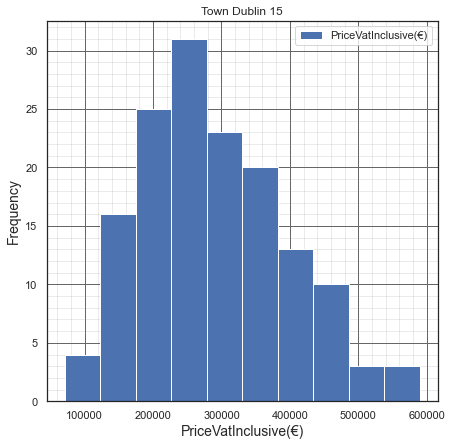

In [47]:
for i in list_for_index:
    df[df['Town'] == i][['PriceVatInclusive(€)']].plot(kind='hist',figsize=(7,7), bins=10, title="Town " + i)
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    plt.ylabel('Frequency',fontsize =14)
    plt.xlabel('PriceVatInclusive(€)',fontsize =14)

#### County VS PriceVatInclusive(€)

<AxesSubplot:title={'center':'PriceVatInclusive(€)'}, xlabel='[County]'>

<Figure size 432x288 with 0 Axes>

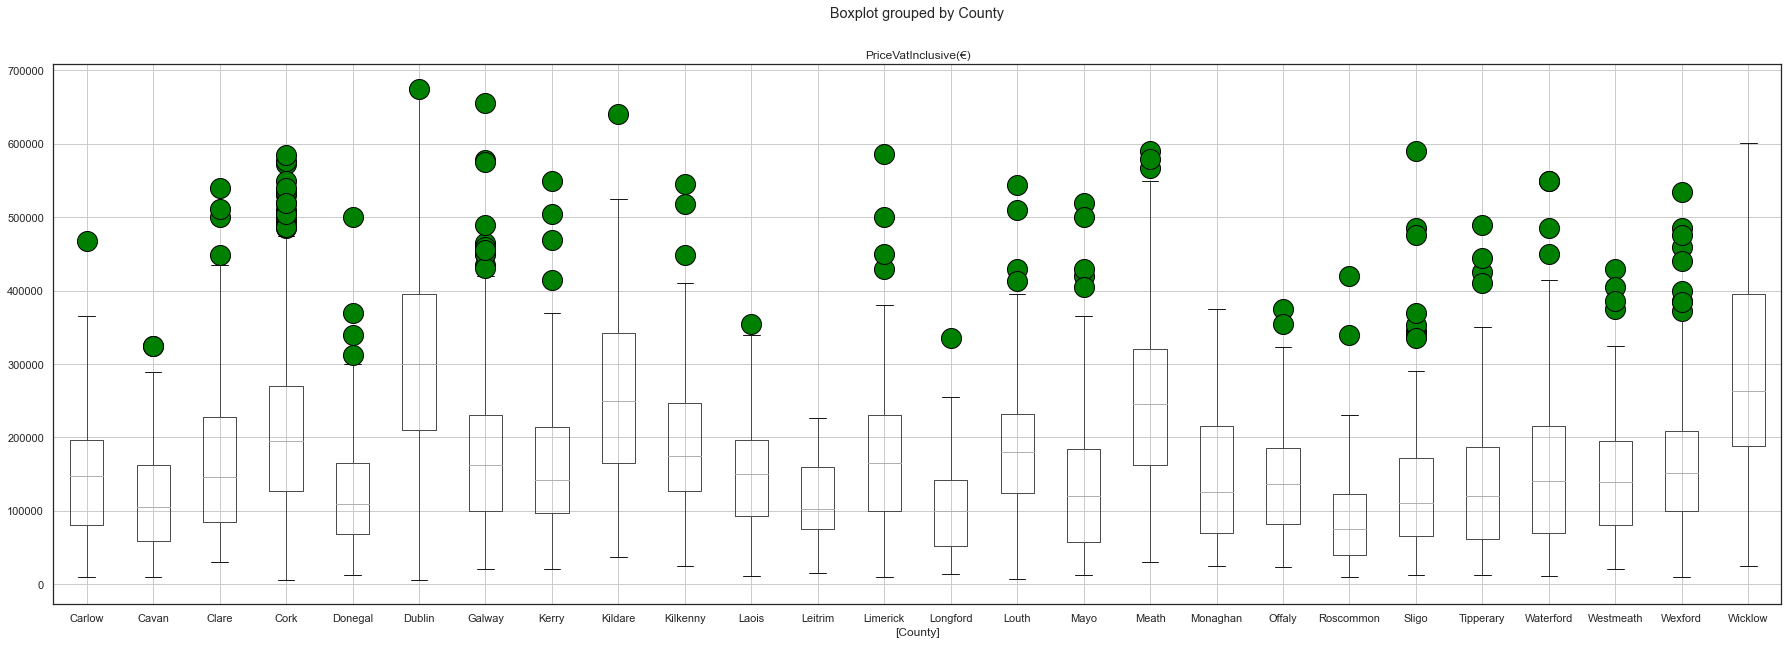

In [48]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=20, 
                  linestyle='none')
df_temp.boxplot(column=['PriceVatInclusive(€)'], by=['County'], flierprops=flierprops, figsize=(30,10))

#### PostalCode VS PriceVatInclusive(€)

<AxesSubplot:title={'center':'PriceVatInclusive(€)'}, xlabel='[PostalCode]'>

<Figure size 432x288 with 0 Axes>

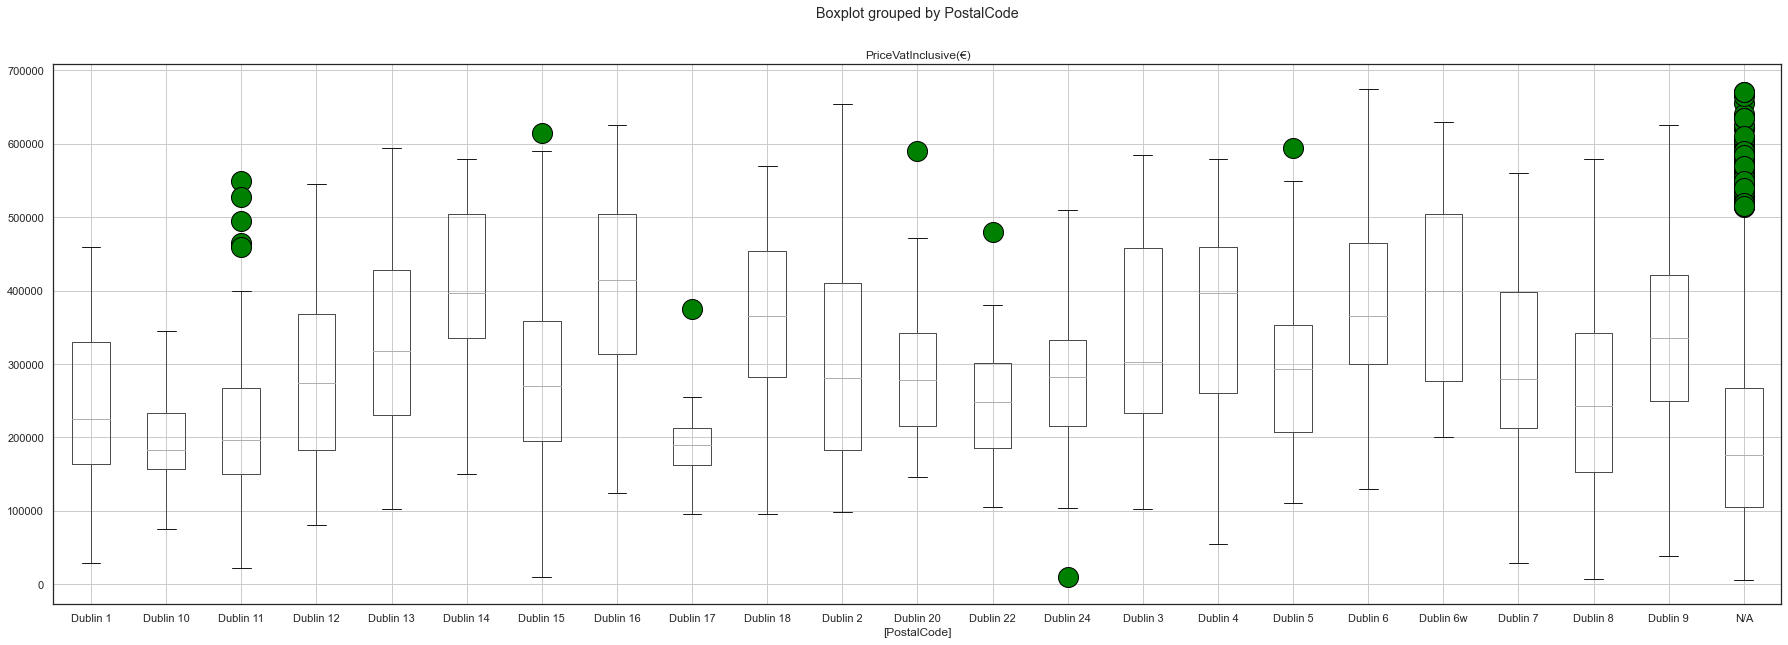

In [49]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=20, 
                  linestyle='none')
df_temp.boxplot(column=['PriceVatInclusive(€)'], by=['PostalCode'], flierprops=flierprops, figsize=(30,10))

#### DescriptionofProperty VS PriceVatInclusive(€)

<AxesSubplot:title={'center':'PriceVatInclusive(€)'}, xlabel='[DescriptionofProperty]'>

<Figure size 432x288 with 0 Axes>

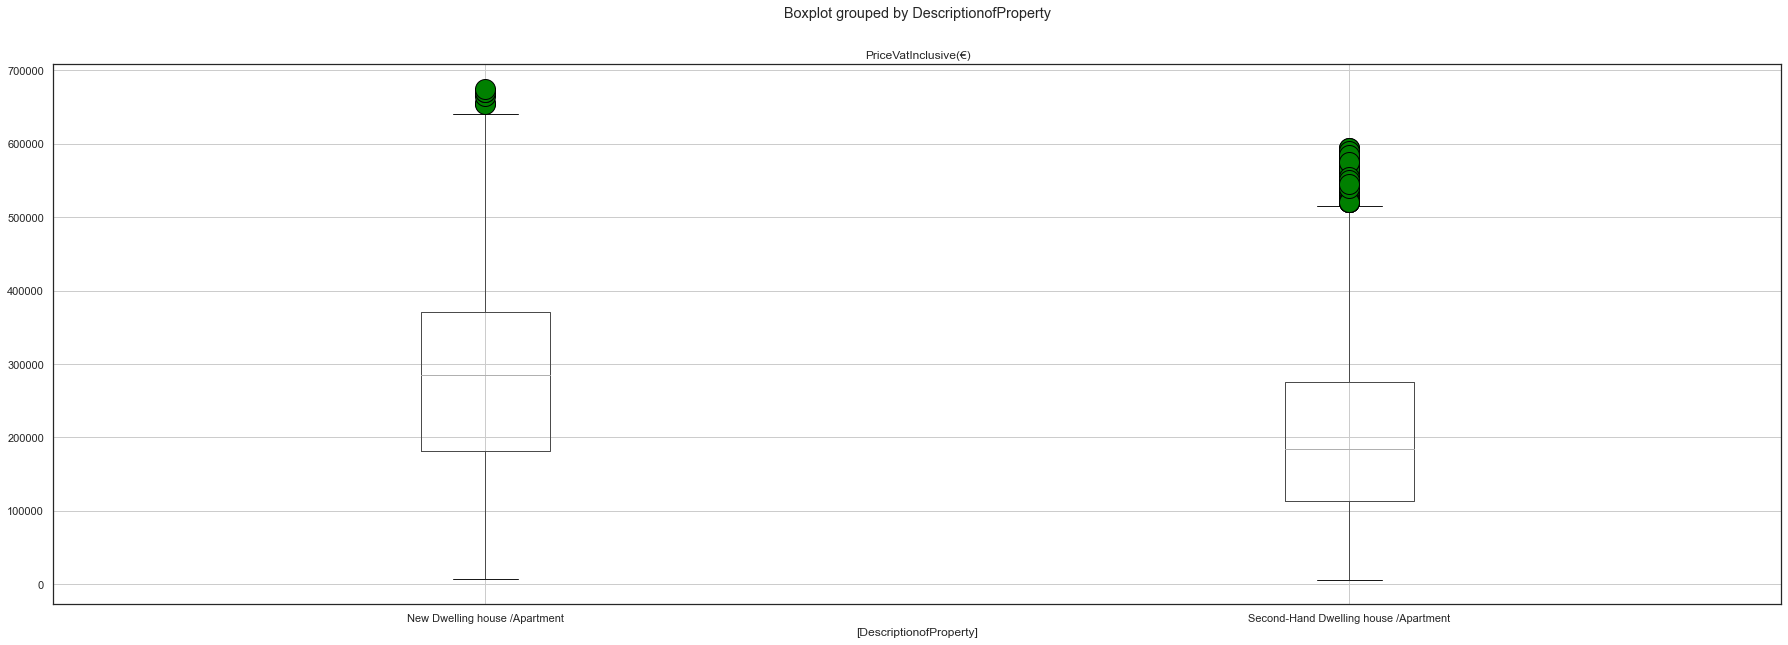

In [50]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=20, 
                  linestyle='none')
df_temp.boxplot(column=['PriceVatInclusive(€)'], by=['DescriptionofProperty'], flierprops=flierprops, figsize=(30,10))

#### PropertySizeDescription VS PriceVatInclusive(€)

<AxesSubplot:title={'center':'PriceVatInclusive(€)'}, xlabel='[PropertySizeDescription]'>

<Figure size 432x288 with 0 Axes>

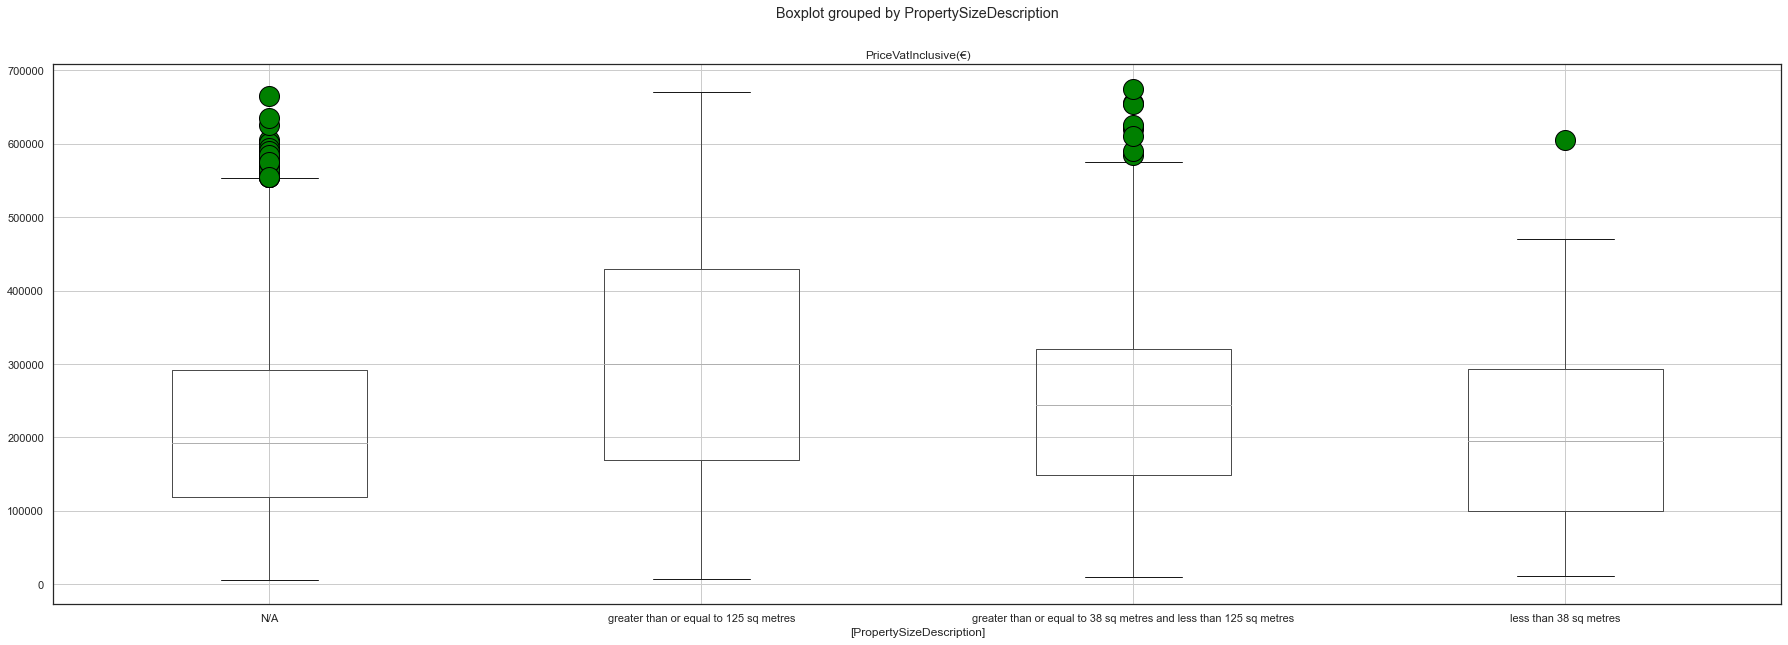

In [51]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=20, 
                  linestyle='none')
df_temp.boxplot(column=['PriceVatInclusive(€)'], by=['PropertySizeDescription'], flierprops=flierprops, figsize=(30,10))

#### Interpretation of the results

There are 6 category features in total, however, the feature *Street* has a high cardinality and therefore is not considered here as well as for the model later.
- Town:
    - From the plot above, we can see that the feature *Town* has impact on the price of the property.
    - We plot out 5 town's price bar chart with highest frequency in the train dataset. Town 'Dublin' has the highest price on average.
    - Because of the nature of high cardinality of this feature, we choose to drop it.
- County:
    - As we can see from the box plots that *County* considerably affects the price of the properties. For example, Dublin County has relatively highest median price of property. Meanwhile, Longford and Roscommom has relatively lowest median price. Therefore, we will keep this feature.
- PostalCode:
    - As we can see from the box plots that *PostalCode* considerably affects the price of the properties. For example, Dublin 14, Dublin 16, Dublin4 and Dublin 6w has relatively higher median price of property, which is around 400000. Meanwhile, Dublin 10 and Dublin 17 has relatively lower median price, which is around 280000. Therefore, we will keep this feature.
    - However, it is expected that the feature *PostalCode* will not have any impact on predicting price for those properties don't have post code.
- DescriptionofProperty:
    - As we can see from the box plot, the price of new dwelling is higher than the price of second-hand dwelling on average. Therefore, we will keep this feature.
- PropertySizeDescription:
    - As we can see from the box plot, porperties of 'greater or equal to 125sq meters' have highest price, while properties of 'greater than or equal to 38 sq meters and less than 125 sq meters' is in the middle and properties of 'less than 38 sq meters' have lowest price. Therefore, this feature will impact the price of property and we will keep this feature.
    - However, it is expected that this feature will have limited influence on predicting price because of the large amount of 'N/A' value.

In [52]:
low_correlation_category_features = ['Street', 'Town']

### 1.2.4 Summary & Drop Features

From the discussion above, we choose to drop the following features for modelling.

In [53]:
low_correlation_continuous_features

['Month', 'Agent Commission']

In [54]:
low_correlation_category_features

['Street', 'Town']

We will now drop these features
- Before dropping we will duplicate the original dataframe, df, and label it df_rev1
- We will drop features from this copy only (df_rev1)
- This will allow us to revert to the original dataset later if we decide to compare the performance of the reduced dataset (df_rev1) with the original dataset (df)

In [55]:
# drop all low correlation features
low_value_features = list(set(low_correlation_continuous_features + low_correlation_category_features))
# before dropping make copy of original
df_rev1 = df.copy()
# drop low value features
df_rev1.drop(low_value_features, 1, inplace=True)
print('\nRemaining columns:', df_rev1.columns)
print('\nNew shape:', df_rev1.shape)


Remaining columns: Index(['Year', 'County', 'PostalCode', 'PriceVatInclusive(€)',
       'DescriptionofProperty', 'PropertySizeDescription',
       'HighestMortgageInterestRate', 'GDP($ Billions)'],
      dtype='object')

New shape: (8983, 8)


In [56]:
# check df_rev1
df_rev1.head(5)

,Year,County,PostalCode,PriceVatInclusive(€),DescriptionofProperty,PropertySizeDescription,HighestMortgageInterestRate,GDP($ Billions)
0,2013,Galway,N/A,235000.0,Second-Hand Dwelling house /Apartment,N/A,0.0438,238.55
1,2014,Kilkenny,N/A,63000.0,Second-Hand Dwelling house /Apartment,N/A,0.0420,259.25
2,2018,Limerick,N/A,264999.8,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,0.0321,386.16
3,2015,Cork,N/A,110000.0,Second-Hand Dwelling house /Apartment,N/A,0.0405,291.64
4,2020,Dublin,Dublin 12,240000.0,Second-Hand Dwelling house /Apartment,N/A,0.0292,418.62


### 1.3 Prepare dataset for modeling
Now we have picked our descriptive features for the whole dataset, a number of additional steps will need to be taken to prepare the dataset for modeling 
- We will now convert the categorical variables into dummies variable to allow modeling
- We will then remove the redundant dummies which contain no additional information
- We will then set up the train test split again based on the dataset with the dummies included

Based on my study from https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/, dummy encoding is necessary to transforms the categorical variable into a set of binary variables (also known as dummy variables) before modelling. The method of dummy encoding is by setting the value of the new continuous feature which corresponds to the level of the categorical feature to 1, and the other continious features to 0.

However, the drawback of dummy encoding is obvious, it creates a lot of new features in the dataset. For example, for the original feature *County*, it will be converted into 25 new features which are *County_Dublin*, *County_Cork* etc. For this reason we carry out the second step above - remove the redundant dummies which contain no additional information. For example, we can assume that a zero in all new features implies that the original cateogrical feature had the first value. We will add the parameter drop_first = True in the code below in order to execute this step.

In [57]:
# set up dummies features
df_rev1 = pd.get_dummies(df_rev1, drop_first=True)
df_rev1.dtypes

Year                                                                                           int64
PriceVatInclusive(€)                                                                         float64
HighestMortgageInterestRate                                                                  float64
GDP($ Billions)                                                                              float64
County_Cavan                                                                                   uint8
County_Clare                                                                                   uint8
County_Cork                                                                                    uint8
County_Donegal                                                                                 uint8
County_Dublin                                                                                  uint8
County_Galway                                                                              

In [58]:
#look at the dummies 
df_rev1.head()

,Year,PriceVatInclusive(€),HighestMortgageInterestRate,GDP($ Billions),County_Cavan,County_Clare,County_Cork,County_Donegal,County_Dublin,County_Galway,...,PostalCode_Dublin 6,PostalCode_Dublin 6w,PostalCode_Dublin 7,PostalCode_Dublin 8,PostalCode_Dublin 9,PostalCode_N/A,DescriptionofProperty_Second-Hand Dwelling house /Apartment,PropertySizeDescription_greater than or equal to 125 sq metres,PropertySizeDescription_greater than or equal to 38 sq metres and less than 125 sq metres,PropertySizeDescription_less than 38 sq metres
0,2013,235000.0,0.0438,238.55,0,0,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
1,2014,63000.0,0.0420,259.25,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2,2018,264999.8,0.0321,386.16,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,2015,110000.0,0.0405,291.64,0,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
4,2020,240000.0,0.0292,418.62,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


Now, we will set up the continuous_columns and categorical_columns.

In [59]:
continuous_columns = df_rev1.select_dtypes(include=['int64','float64']).columns.tolist()
# remove the target "RiskPerformance"
continuous_columns.pop(0)
continuous_columns

['PriceVatInclusive(€)', 'HighestMortgageInterestRate', 'GDP($ Billions)']

In [60]:
categorical_columns = df_rev1.select_dtypes(include=['uint8']).columns.tolist()
categorical_columns

['County_Cavan',
 'County_Clare',
 'County_Cork',
 'County_Donegal',
 'County_Dublin',
 'County_Galway',
 'County_Kerry',
 'County_Kildare',
 'County_Kilkenny',
 'County_Laois',
 'County_Leitrim',
 'County_Limerick',
 'County_Longford',
 'County_Louth',
 'County_Mayo',
 'County_Meath',
 'County_Monaghan',
 'County_Offaly',
 'County_Roscommon',
 'County_Sligo',
 'County_Tipperary',
 'County_Waterford',
 'County_Westmeath',
 'County_Wexford',
 'County_Wicklow',
 'PostalCode_Dublin 10',
 'PostalCode_Dublin 11',
 'PostalCode_Dublin 12',
 'PostalCode_Dublin 13',
 'PostalCode_Dublin 14',
 'PostalCode_Dublin 15',
 'PostalCode_Dublin 16',
 'PostalCode_Dublin 17',
 'PostalCode_Dublin 18',
 'PostalCode_Dublin 2',
 'PostalCode_Dublin 20',
 'PostalCode_Dublin 22',
 'PostalCode_Dublin 24',
 'PostalCode_Dublin 3',
 'PostalCode_Dublin 4',
 'PostalCode_Dublin 5',
 'PostalCode_Dublin 6',
 'PostalCode_Dublin 6w',
 'PostalCode_Dublin 7',
 'PostalCode_Dublin 8',
 'PostalCode_Dublin 9',
 'PostalCode_N/A',


In [61]:
features = continuous_columns + categorical_columns
features

['PriceVatInclusive(€)',
 'HighestMortgageInterestRate',
 'GDP($ Billions)',
 'County_Cavan',
 'County_Clare',
 'County_Cork',
 'County_Donegal',
 'County_Dublin',
 'County_Galway',
 'County_Kerry',
 'County_Kildare',
 'County_Kilkenny',
 'County_Laois',
 'County_Leitrim',
 'County_Limerick',
 'County_Longford',
 'County_Louth',
 'County_Mayo',
 'County_Meath',
 'County_Monaghan',
 'County_Offaly',
 'County_Roscommon',
 'County_Sligo',
 'County_Tipperary',
 'County_Waterford',
 'County_Westmeath',
 'County_Wexford',
 'County_Wicklow',
 'PostalCode_Dublin 10',
 'PostalCode_Dublin 11',
 'PostalCode_Dublin 12',
 'PostalCode_Dublin 13',
 'PostalCode_Dublin 14',
 'PostalCode_Dublin 15',
 'PostalCode_Dublin 16',
 'PostalCode_Dublin 17',
 'PostalCode_Dublin 18',
 'PostalCode_Dublin 2',
 'PostalCode_Dublin 20',
 'PostalCode_Dublin 22',
 'PostalCode_Dublin 24',
 'PostalCode_Dublin 3',
 'PostalCode_Dublin 4',
 'PostalCode_Dublin 5',
 'PostalCode_Dublin 6',
 'PostalCode_Dublin 6w',
 'PostalCode_D

### Setting up the train/test split
- This is based on the dataset with dummy values
- The Target is stored in dataframe "y"
- The remaining features are stored in dataframe "X"
- Both are split into training and test subsets

In [62]:
# y is the target
y = df_rev1["PriceVatInclusive(€)"]
# X is everything else
X = df_rev1.drop(["PriceVatInclusive(€)"],1)
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,  test_size=0.3)

print("original range is: ",df_rev1.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  8983
training range (70%):	 rows 0 to 6288
test range (30%): 	 rows 6288 to 8983


In [63]:
print(X)

      Year  HighestMortgageInterestRate  GDP($ Billions)  County_Cavan  \
0     2013                       0.0438           238.55             0   
1     2014                       0.0420           259.25             0   
2     2018                       0.0321           386.16             0   
3     2015                       0.0405           291.64             0   
4     2020                       0.0292           418.62             0   
...    ...                          ...              ...           ...   
8978  2021                       0.0280           440.00             0   
8979  2021                       0.0280           440.00             0   
8980  2014                       0.0420           259.25             0   
8981  2016                       0.0361           299.76             0   
8982  2021                       0.0280           440.00             0   

      County_Clare  County_Cork  County_Donegal  County_Dublin  County_Galway  \
0                0            

In [64]:
print(y)

0       235000.0
1        63000.0
2       264999.8
3       110000.0
4       240000.0
          ...   
8978    150000.0
8979     79000.0
8980    460000.0
8981    359999.3
8982    155000.0
Name: PriceVatInclusive(€), Length: 8983, dtype: float64


In [65]:
print("\nDescriptive features in X:\n", X_train.head(5))
print("\nTarget feature in y:\n", y_train.head(5))


Descriptive features in X:
       Year  HighestMortgageInterestRate  GDP($ Billions)  County_Cavan  \
7602  2016                       0.0361           299.76             0   
4192  2014                       0.0420           259.25             0   
4485  2016                       0.0361           299.76             0   
4741  2016                       0.0361           299.76             0   
2537  2016                       0.0361           299.76             0   

      County_Clare  County_Cork  County_Donegal  County_Dublin  County_Galway  \
7602             0            0               0              0              0   
4192             0            1               0              0              0   
4485             0            0               0              0              1   
4741             0            0               0              0              0   
2537             0            0               0              0              0   

      County_Kerry  ...  PostalCode_Dub

In [66]:
X_train.head(5)

,Year,HighestMortgageInterestRate,GDP($ Billions),County_Cavan,County_Clare,County_Cork,County_Donegal,County_Dublin,County_Galway,County_Kerry,...,PostalCode_Dublin 6,PostalCode_Dublin 6w,PostalCode_Dublin 7,PostalCode_Dublin 8,PostalCode_Dublin 9,PostalCode_N/A,DescriptionofProperty_Second-Hand Dwelling house /Apartment,PropertySizeDescription_greater than or equal to 125 sq metres,PropertySizeDescription_greater than or equal to 38 sq metres and less than 125 sq metres,PropertySizeDescription_less than 38 sq metres
7602,2016,0.0361,299.76,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
4192,2014,0.0420,259.25,0,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
4485,2016,0.0361,299.76,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,0
4741,2016,0.0361,299.76,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2537,2016,0.0361,299.76,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


#### Reset the indexes of the training and test splits
- We can see from the output above that the indexes are no longer consecutive for any of the dataframes. 
- We will fix this now so that we are able to merge the dataframes later in the assignment.

In [67]:
# need to reset the index to allow contatenation with predicted values otherwise not joining on same index...
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_train.head(5)

,Year,HighestMortgageInterestRate,GDP($ Billions),County_Cavan,County_Clare,County_Cork,County_Donegal,County_Dublin,County_Galway,County_Kerry,...,PostalCode_Dublin 6,PostalCode_Dublin 6w,PostalCode_Dublin 7,PostalCode_Dublin 8,PostalCode_Dublin 9,PostalCode_N/A,DescriptionofProperty_Second-Hand Dwelling house /Apartment,PropertySizeDescription_greater than or equal to 125 sq metres,PropertySizeDescription_greater than or equal to 38 sq metres and less than 125 sq metres,PropertySizeDescription_less than 38 sq metres
0,2016,0.0361,299.76,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1,2014,0.0420,259.25,0,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2,2016,0.0361,299.76,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,0
3,2016,0.0361,299.76,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
4,2016,0.0361,299.76,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


Now the datasets are ready for training.

# 2) Predictive Modeling and Evaluation: Linear Regression.

## 2.1) On the training set, train a linear regression model to predict the target feature. For training, we will use only the train split from the train/test split performed above.

In [68]:
# Train aka fit, a model using all continuous and categorical features.
multiple_linreg = LinearRegression().fit(X_train, y_train)

## 2.2) Understand the model and print out the coefficients learned by the model.

In [69]:
#Print out the weights that have been learned for each feature.
print("\nFeatures are: \n", X_train.columns)
print("\nCoeficients are: \n", multiple_linreg.coef_)
print("\nIntercept is: \n", multiple_linreg.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_train.columns, multiple_linreg.coef_)))


Features are: 
 Index(['Year', 'HighestMortgageInterestRate', 'GDP($ Billions)',
       'County_Cavan', 'County_Clare', 'County_Cork', 'County_Donegal',
       'County_Dublin', 'County_Galway', 'County_Kerry', 'County_Kildare',
       'County_Kilkenny', 'County_Laois', 'County_Leitrim', 'County_Limerick',
       'County_Longford', 'County_Louth', 'County_Mayo', 'County_Meath',
       'County_Monaghan', 'County_Offaly', 'County_Roscommon', 'County_Sligo',
       'County_Tipperary', 'County_Waterford', 'County_Westmeath',
       'County_Wexford', 'County_Wicklow', 'PostalCode_Dublin 10',
       'PostalCode_Dublin 11', 'PostalCode_Dublin 12', 'PostalCode_Dublin 13',
       'PostalCode_Dublin 14', 'PostalCode_Dublin 15', 'PostalCode_Dublin 16',
       'PostalCode_Dublin 17', 'PostalCode_Dublin 18', 'PostalCode_Dublin 2',
       'PostalCode_Dublin 20', 'PostalCode_Dublin 22', 'PostalCode_Dublin 24',
       'PostalCode_Dublin 3', 'PostalCode_Dublin 4', 'PostalCode_Dublin 5',
       'PostalC

### Discussion of coefficients
Before discussing the weights printout out above, we will first introduce linear regression.

- Linear regression is a supervised machine learning method which is used to make predictions based on a linear relationship between the target (dependent variable) and any number of independent variables (also known as predictors).
- It finds the line of best fit that describes the relationship between the target and predictors/variables. 
- The linear regression formula takes the following form:
    - $target\_feature = w_0 + w_1 * feature_1 + w_2*feature_2 + ...+ w_n*feature_n $
- From the formula above, w_0 is known as intercept, w_1, w_2, w_n, etc are known as coefficients.
- By achieving the best-fit regression line, the model aims to predict y value such that the error difference between predicted value and true value is minimum.
- As seen in the image below, this is usually done using the least squares criterion. In other words, we find the line of best fit that describes the relationship between the target and predictors which minimises the sum of squared residuals (also known as sum of squared errors).
    - The **black** dots are the observed values of x and y.
    - The **blue line** is the regression line we achieve. 
    - The **red lines** are the residuals. We need to minimise the distance of these red lines in order to achieve a more accurate regression line. 
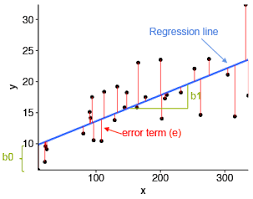

Source: https://rpubs.com/cuborican/regression

**Discussing the coefficients learned by the model:**
- There are too many coefficients to discuss all in detail however we will explain their meaning and discuss some as an example. 
- We can see above that the intercept is 18714186.75 (this is w_0 in the formula above). This is the value of y when x is zero. In other words it is where the model intercepts the x axis. If all other coefficients were zero, the model result would be 18714186.75.
- We can see above that the coefficients for each features above, some of them are positive and some are negative. Generally speaking, the sign of a regression coefficient tells us whether there is a positive or negative correlation between independent variables (X) and dependent variable (Y). Positive correlation means Y will increase when X increases, while negative correlation means Y will decrease when X increases. 

## 2.3) Printing 10 predicted target features and evaluate the prediction
- Here we will print the predicted target feature value for the first 10 training examples. 
- Also, we will print a few regression evaluation measures computed on the full training set and discuss our findings.

In [70]:
# calculate the prediction
multiple_linreg_predictions_train = multiple_linreg.predict(X_train)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_train, pd.DataFrame(multiple_linreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(10))


Predictions with multiple linear regression: 

   PriceVatInclusive(€)      Predicted
0           210000.0000  210225.032332
1           120000.0000  157932.712411
2           102500.0000  163469.982664
3           430000.0000  150325.829137
4           258999.0550  243517.903696
5           120000.0000  157932.712411
6            55000.0000  129793.956211
7           132500.0000  154530.333081
8           142999.9893  187823.204444
9           120000.0000  217044.229210


From the 10 training examples above, we are easy to find out that the linear regression model is able to give an accurate prediction in a certain extent. Now we will introduce some evaluation measures to analyse the performance of regression model that we applied above.

Before we starting the evaluation, we will introduce some common evaluation metrics in Linear Regression.
- Mean Absolute Error (MAE): This is simply the average of the absolute difference between the target value and the value predicted by the model.
- Root Mean Squared Error (RMSE): This is the square root of the average of the squared difference of the predicted and actual value.
- R-squared (R2): 
    - This metric represents the part of the variance of the dependent variable explained by the independent variables of the model. It measures the strength of the relationship between our model and the dependent variable.
    - The value for R-squared can range from 0 to 1. A value of 0 indicates that the response variable cannot be explained by the predictor variable at all. A value of 1 indicates that the response variable can be perfectly explained without error by the predictor variable.
    
Source: https://towardsdatascience.com/evaluation-metrics-model-selection-in-linear-regression-73c7573208be

In [71]:
#This function is used repeatedly to compute all metrics
def printMetrics(testActualVal, predictions):
    #classification evaluation measures
    print('\n==============================================================================')
    print("MAE: ", metrics.mean_absolute_error(testActualVal, predictions))
    #print("MSE: ", metrics.mean_squared_error(testActualVal, predictions))
    print("RMSE: ", metrics.mean_squared_error(testActualVal, predictions)**0.5)
    print("R2: ", metrics.r2_score(testActualVal, predictions))
        

In [72]:
printMetrics(y_train, multiple_linreg_predictions_train)


MAE:  75521.39466359625
RMSE:  98155.76594997269
R2:  0.4319833903593988


### Discussion of the results

- Generally speaking, the values of MAE and RMSE are smaller, the model is better. And the value of R2 is closer to 1, the prediction is more accurate.
- MAE tells us how big of an error we can expect from the forecast on average. In the linear regression model, the MAE is 75521.39.
- RMSE tells us the square root of the average of the squared difference of the predicted and actual value. The RMSE value here is 98155.77.
- RMSE should always be higher than or equal to MAE, and if RMSE is much higher than MAE, it (loosely) means that the error variance is high. It could mean that we probably have outliers in our data. In the linear regression model, the difference between RMSE and MAE is 22634.38.
- R2 tells us the coefficient of how well the values fit compared to the original values. The R2 value for linear regression model is 0.43.
- Althought the value of 0.43 does not seem to be outstanding as the value of R2, we don’t outright reject the model with lower R-Squared. Because sometimes a lower R-squared model can be a good model for several other reasons, for example model might have high R-squared and be highly biased. If we have a low R-squared value but the independent variables are statistically significant, we can still draw important conclusions about the relationships between the variables.
- We could not summarize more information for now because we need results from other models as references. Deeper discussion will be given later.

## 2.4) Evaluate the model using the hold-out (30% examples) test set
- The results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e. a new model trained and evaluated using cross-validation on the full dataset).

In [73]:
linreg_predictions = multiple_linreg.predict(X_test)

print("\nPredictions with linear regression: \n")
actual_vs_predicted_linreg = pd.concat([y_test, pd.DataFrame(linreg_predictions, columns=['Predicted'], index=y_test.index)], axis=1)
print(actual_vs_predicted_linreg)


Predictions with linear regression: 

      PriceVatInclusive(€)      Predicted
0              55000.00000   76593.680635
1             170655.26000  271857.297426
2             160000.00000  306878.544718
3             295000.00000  280757.673634
4              69999.99000  167112.231501
...                    ...            ...
2690          340000.00000  131822.226081
2691          344999.99125  311750.225930
2692          130000.00000  170057.370939
2693          540000.08500  310695.654250
2694          115000.00000  150325.829137

[2695 rows x 2 columns]


In [74]:
printMetrics(y_test, linreg_predictions)


MAE:  77746.7179687047
RMSE:  100553.06156987736
R2:  0.41325275214405144


### Discussion of the result

We will now discuss the results for the test data and compare it to the training data.

- MAE: The value of MAE increases slightly from 75521.39 in training data to 77746.72.
- RMSE: The value of RMSE increases slightly from 98155.77 in training data to 100553.06.
- The difference value between RMSE and MAE is 22806.34, which maintains at the same level at the value in training data.
- R2: The value of R2 decreases slightly from 0.43 to 0.41.

**Summary**

Generally, We are pleased with these results as we are now testing the predictive model on data that has not been seen before. We see decreases in some scores but they are only slight. This is a good sign that the model is generalising to new data.

### Evaluation with cross-validation

We will now perform cross-validation on the linear regression model. 

- We will use K-fold cross-validation since it is simple to understand and it generally results in a less biased or less optimistic estimate of the model skill than other methods, such as a simple train/test split.
- Using cross validation we do repeated train/test splits and average the error on the test datasets. Thus, it can result in a less biased result than a simple train/test split. 
- We will set the value of 'k' to 10, as is explained from https://machinelearningmastery.com/k-fold-cross-validation/, a value of k=10 is very common in the field of applied machine learning, and is recommended in the most of the situation.

We will begin by creating a function to perform cross-validation

In [75]:
def linreg_cross_validation(X_set,y_set,k):
    
    linreg_Results = {}
    
    print("=======================MAE===========================")
    MAE_scores = -cross_val_score(LinearRegression(), X_set,y_set, scoring='neg_mean_absolute_error', cv=k)
    print(MAE_scores)
    print("Avg MAE score over 10 folds:", np.mean(MAE_scores))
    print("Stddev MAE score over 10 folds:", np.std(MAE_scores))
    linreg_Results['MAE'] = np.mean(MAE_scores)
    
    print("\n=====================RMSE==========================")
    RMSE_scores = -cross_val_score(LinearRegression(), X_set,y_set, scoring='neg_mean_squared_error', cv=k)
    print(RMSE_scores)
    rmse = RMSE_scores**0.5
    print("Avg RMSE score over 10 folds:", np.mean(rmse))
    print("Stddev RMSE score over 10 folds:", np.std(rmse))
    linreg_Results['RMSE'] = np.mean(rmse)
    
    print("\n======================R2===========================")
    R2_scores = cross_val_score(LinearRegression(), X_set,y_set, scoring='r2', cv=k)
    print(R2_scores)
    print("Avg R2 score over 10 folds:", np.mean(R2_scores))
    print("Stddev R2 score over 10 folds:", np.std(R2_scores))
    linreg_Results['R2'] = np.mean(R2_scores)
    
    linreg_DF = pd.DataFrame.from_dict(linreg_Results, orient = 'index', columns=['Linear_Regression'])
    return linreg_DF
    

We will perform cross-validation for train set.

In [76]:
linreg_cross_validation(X_train,y_train,10)

=======================MAE===========================
[75407.27589399 76379.74128137 77689.01356946 70780.39430168
 78369.45122997 76713.46455377 77388.0588459  80715.20358201
 71345.79395614 77610.68519401]
Avg MAE score over 10 folds: 76239.90824083093
Stddev MAE score over 10 folds: 2907.8538447320357

=====================RMSE==========================
[9.74492603e+09 1.00345932e+10 9.72159606e+09 8.65614907e+09
 1.00618359e+10 9.80544126e+09 1.00740334e+10 1.11263867e+10
 8.92041455e+09 1.00505111e+10]
Avg RMSE score over 10 folds: 99040.8279466774
Stddev RMSE score over 10 folds: 3240.8542479791467

======================R2===========================
[0.43892008 0.45349877 0.43003358 0.43634853 0.39268522 0.41022663
 0.43772753 0.37425216 0.44900725 0.38192446]
Avg R2 score over 10 folds: 0.4204624201945048
Stddev R2 score over 10 folds: 0.027176937036108993


,Linear_Regression
MAE,76239.908241
RMSE,99040.827947
R2,0.420462


We will perform cross-validation for test set.

In [77]:
linreg_cross_validation(X_test,y_test,10)

=======================MAE===========================
[85511.05230742 81956.32333907 73613.41065618 80408.57632608
 82329.91006723 81233.72419721 71709.66670638 81611.39754857
 72141.76910395 75039.57131265]
Avg MAE score over 10 folds: 78555.54015647336
Stddev MAE score over 10 folds: 4678.933043763166

=====================RMSE==========================
[1.26130638e+10 1.11723481e+10 9.06664372e+09 1.04423170e+10
 1.08309910e+10 1.08603189e+10 8.19607575e+09 1.12732752e+10
 8.77273346e+09 1.00260549e+10]
Avg RMSE score over 10 folds: 101419.96304155595
Stddev RMSE score over 10 folds: 6274.812623359795

======================R2===========================
[0.31374275 0.38447179 0.42985817 0.34688675 0.38812927 0.4328941
 0.43088936 0.43746391 0.37917248 0.43811628]
Avg R2 score over 10 folds: 0.39816248561583206
Stddev R2 score over 10 folds: 0.04102130006169629


,Linear_Regression
MAE,78555.540156
RMSE,101419.963042
R2,0.398162


#### Interpretation of cross-validation results. 
- Here we have the average of 10-fold cross-validations for both train dataset and test dataset. 
- Train set:
    - Avg MAE score is 76239.91, Avg RMSE score is 99040.83, which are both slightly higher than the results from single train linear regression model. 
    - R2 is 0.42, which is quite the same as the result from the single train model.
    
- Test set:
    - Similar to the train set, the Avg MAE and Avg RMSE both grow slightly higher than the results frim single test model, which are 78555.54 and 101419.96.
    - R2 is 0.40, which is quite the same as the result from the single train model.
    - We can see that the Stddev values of MAE, RMSE and R2 in test set are all higher than the values in train dataset, which means there is greater variability in the test dataset.

**Summary**

We are pleased with these results as we can see there is no huge difference in the results between single train/test model and cross-validation model.

# 3) Predictive Modeling and Evaluation: Decision Tree

## 3.1) On the training set, train a decision tree model to predict the target feature, using the descriptive features selected in exercise (1) above.

- We will now train a decision tree model on our data.
- As we are working on a regression problem, we will use regression trees. 
- We use the RandomForestRegression() function. 
- The 'random_state' will be set to 1 to allow the results to be repeated. This means that any ties between features will be split in the same way each time we run the code, thus giving us the same tree each time.
- We will set one tree with max_depth=4 and the other with max_depth=8. We will train two in order to demonstrate how the max_depth parameter works. And we will pick one which can demonstrate the decision tree in a better way.

In [78]:
# Instantiate sklearn estimator, fit with training set.
# Train a classification tree with max_depth=4 and another one with max_depth=8.
dtc4 = DecisionTreeRegressor(max_depth=4, random_state=1)
dtc4.fit(X_train, y_train)
dtc8 = DecisionTreeRegressor(max_depth=8, random_state=1)
dtc8.fit(X_train, y_train)
print("Max depth 4: \n",dtc4)
print("Max depth 8: \n",dtc8)

Max depth 4: 
 DecisionTreeRegressor(max_depth=4, random_state=1)
Max depth 8: 
 DecisionTreeRegressor(max_depth=8, random_state=1)


## 3.2) Understand the model and discuss the knowledge gained in regard of the working of this model. 

Before we analyse the results of the model, we will first introduce the Decision Tree Model.

**Decision Tree:**
- Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. Here we will use the regression decision tree.
- The decision on which feature to split on is based on the information gain (Gini index). 
- The tree will always split on the feature that gives the highest information gain
- The feature with the highest information gain will sit at the root of each decision tree
- Each decision tree will be a single prediction

(Theoratical knowledge from: sample_solution_COMP47350_Task2_PredictiveModeling_Evaluation_CreditRiskPrediction)



We will display the decision trees we created above.

In [79]:
# create a Graphviz png
with open("DecisionTree4.dot", 'w') as f1:
    f1 = export_graphviz(dtc4, out_file=f1, feature_names=X_train.columns)
with open("DecisionTree8.dot", 'w') as f2:
    f2 = export_graphviz(dtc8, out_file=f2, feature_names=X_train.columns)
!dot -Tpng DecisionTree4.dot -o DecisionTree4.png
!dot -Tpng DecisionTree8.dot -o DecisionTree8.png

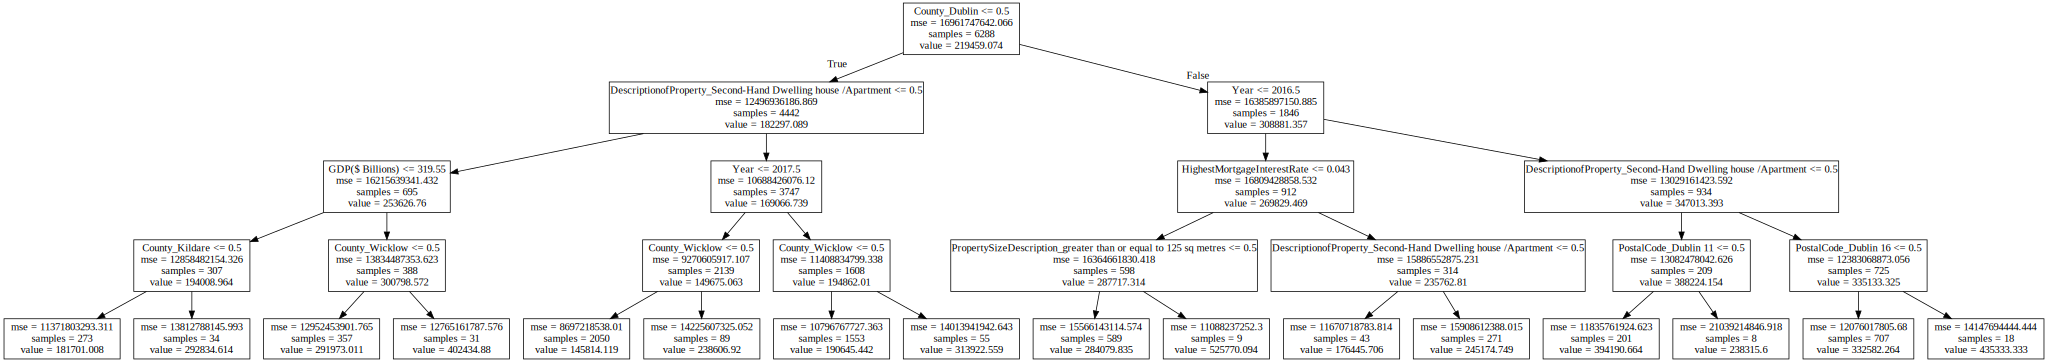

In [80]:
path = './DecisionTree4.dot'
s = Source.from_file(path)
#s.view()
s

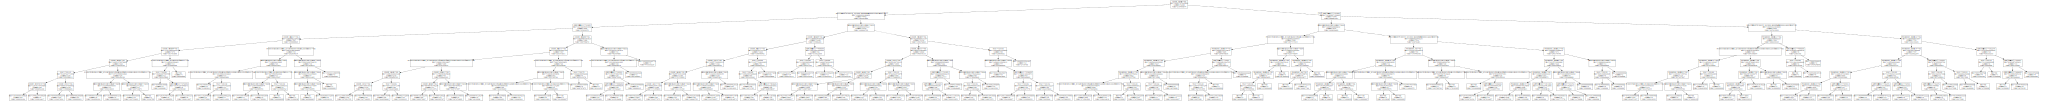

In [81]:
path = './DecisionTree8.dot'
s = Source.from_file(path)
#s.view()
s

As we can see from the graphs above, decision tree can be divided into internal nodes and leaves:

Internal nodes:
- "samples" is the number of observations in that node before splitting
- "mse" is the mean squared error calculated by comparing the actual response values in that node against the mean response value in that node
- first line is the condition used to split that node (go left if true, go right if false)

Leaves:
- "samples" is the number of observations in that node
- "value" is the mean response value in that node
- "mse" is the mean squared error calculated by comparing the actual response values in that node against "value"

For simplicity, we will only discuss the decision tree above with max_depth=4.

- We can see that the root node is County_Dublin, with MSE value of 16961747642.066. There are 6288 number of observations in this node before splitting.
- The root node is the place where model will execute the very first check of data. If 'County_Dublin' = 1, it will go left and check the value of 'DescriptionofProperty', else, it will go right and check the value of 'Year'.
- For each split the the model selects the next best feature and this continues until it reaches a leaf node where the data cannot be split anymore.
- We can see one path below is resolved in 4 branches:
    - County_Dublin <= 0.5;
    - DescriptionofProperty_Second-Hand Dwelling house /Apartment <= 0.5;
    - GDP($ Billions) <= 319.55;
    - County_Kildare <= 0.5;
    - get prediction value of 181701.008.

Now we will check the importance of each feature. (dtc4 as example)
- As mentioned above, the random forest keeps track of the importance of features.
- The list of importances are shown below. 
- The more important features are the features that the random forest has identified as having higher information gain. 
- This list will give us an idea of which features are the most important to keep as we move forward with our modelling.

In [82]:
# Compute the importance of each feature based on the trained decision tree regressor
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance':dtc4.feature_importances_})
feature_importance.sort_values('importance', ascending=False)

,feature,importance
7,County_Dublin,0.580323
50,DescriptionofProperty_Second-Hand Dwelling hou...,0.133990
0,Year,0.128398
2,GDP($ Billions),0.054282
27,County_Wicklow,0.052483
1,HighestMortgageInterestRate,0.015435
51,PropertySizeDescription_greater than or equal ...,0.014381
10,County_Kildare,0.010371
29,PostalCode_Dublin 11,0.005192
34,PostalCode_Dublin 16,0.005147


## 3.3) Print the predicted target feature value for the first 10 training examples
- Here we will print the predicted target feature value for the first 10 training examples. 
- We will apply both dtc4 model and dtc8 model and evaluate the performance of each model.

In [83]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
dtc4_predictions_train = dtc4.predict(X_train)
df_true_vs_dtc_predicted = pd.DataFrame({'ActualClass': y_train, 'PredictedClass': dtc4_predictions_train})
df_true_vs_dtc_predicted.head(10)

,ActualClass,PredictedClass
0,210000.0000,145814.119395
1,120000.0000,145814.119395
2,102500.0000,145814.119395
3,430000.0000,145814.119395
4,258999.0550,181701.008099
5,120000.0000,145814.119395
6,55000.0000,145814.119395
7,132500.0000,145814.119395
8,142999.9893,181701.008099
9,120000.0000,245174.749114


In [84]:
printMetrics(y_train, dtc4_predictions_train)


MAE:  83454.04125757533
RMSE:  105997.35307554112
R2:  0.33760134296795963


In [85]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
dtc8_predictions_train = dtc8.predict(X_train)
df_true_vs_dtc_predicted = pd.DataFrame({'ActualClass': y_train, 'PredictedClass': dtc8_predictions_train})
df_true_vs_dtc_predicted.head(10)

,ActualClass,PredictedClass
0,210000.0000,211241.870588
1,120000.0000,154726.520000
2,102500.0000,143980.817224
3,430000.0000,143980.817224
4,258999.0550,193732.693163
5,120000.0000,154726.520000
6,55000.0000,119034.648030
7,132500.0000,154726.520000
8,142999.9893,209009.361019
9,120000.0000,245453.726130


In [86]:
printMetrics(y_train, dtc8_predictions_train)


MAE:  75879.31546523968
RMSE:  98061.1604447778
R2:  0.4330778059727596


### Discussion of the results

- In the dtc4 model, we set the max depth into 4, which means decisions need to be made within 4 branchs. In dtc4 model, MAE = 83454.04, RMSE = 105997.35, R2 = 0.34. Thus, the performance is generally less than the one in linear regression model we implemented above.

- In the dtc8 model, we improve the max depth up to 8, so it is expected that the prediction will be more accurate compared to dtc8 model.
- As our expectation, MAE = 75879.31, RMSE = 98061.16, R2 = 0.43, so the performance is better than the dtc4 model.
- However, we need to note that, although a deeper decision tree enables a more accurate prediction because we will have more splits and it captures more information about the data like the example above. Over-deep decision tree could be one of the root causes of overfitting in decision trees because the model will fit perfectly for the training data and will not be able to generalize well on test set.

## 3.4 Evaluate the model using the hold-out (30% examples) test set
- These results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).
- From the discussion above, we found out that dtc8 model perform better than dtc4, so in the following steps, we will mainly focus on the dtc8 model.

Printing Actual RiskPerformance vs predicted based on test data

In [87]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
dtc_predictions_test = dtc8.predict(X_test)
df_true_vs_dtc_predicted_test = pd.DataFrame({'ActualClass': y_test, 'PredictedClass': dtc_predictions_test})
df_true_vs_dtc_predicted_test.head(20)

,ActualClass,PredictedClass
0,55000.000,143980.817224
1,170655.260,245453.726130
2,160000.000,338657.263414
3,295000.000,271975.000000
4,69999.990,133437.924078
5,70000.000,119034.648030
6,205000.000,271581.566151
7,275000.000,168627.462750
8,295100.000,268375.006250
9,155000.000,143980.817224


In [88]:
printMetrics(y_test, dtc_predictions_test)


MAE:  81586.84016428197
RMSE:  105095.37582521571
R2:  0.35904479314968984


### Discussion of the result

We will now discuss the results for the test data and compare it to the training data.

- MAE: The value of MAE increases from 75879.31 in training data to 81586.84.
- RMSE: The value of RMSE increases from 98061.16 in training data to 105095.38.
- R2: The value of R2 decreases from 0.43 to 0.36.

**Summary**

The accuracy for the test data is 36%, which is considered to be not accurate enough. The results are expectable considering that we are testing on data the model has not seen before. And one of the disadvantage of decision tree model is a small change in the data can cause a large change in the structure of the decision tree causing instability. And this explain the reason why the accuracy of test data decrease sharply (from 0.43 to 0.36) while in the linear regression model there is just a slight change. 
Generally, We think these results are still acceptable as we are now testing the predictive model on data that has not been seen before. And this is a good sign that the model is generalising to new data.

### Cross-validation
- Now we will implement the cross-validation

In [89]:
def dtc_cross_validation(X_set,y_set,i,k):
    
    dtc_Results = {}
    
    print("=======================MAE===========================")
    MAE_scores = -cross_val_score(DecisionTreeRegressor(max_depth=i, random_state=1), X_set,y_set, scoring='neg_mean_absolute_error', cv=k)
    print(MAE_scores)
    print("Avg MAE score over 10 folds:", np.mean(MAE_scores))
    print("Stddev MAE score over 10 folds:", np.std(MAE_scores))
    dtc_Results['MAE'] = np.mean(MAE_scores)
    
    print("\n=====================RMSE==========================")
    RMSE_scores = -cross_val_score(DecisionTreeRegressor(max_depth=i, random_state=1), X_set,y_set, scoring='neg_mean_squared_error', cv=k)
    print(RMSE_scores)
    rmse = RMSE_scores**0.5
    print("Avg RMSE score over 10 folds:", np.mean(rmse))
    print("Stddev RMSE score over 10 folds:", np.std(rmse))
    dtc_Results['RMSE'] = np.mean(rmse)
    
    print("\n======================R2===========================")
    R2_scores = cross_val_score(DecisionTreeRegressor(max_depth=i, random_state=1), X_set,y_set, scoring='r2', cv=k)
    print(R2_scores)
    print("Avg R2 score over 10 folds:", np.mean(R2_scores))
    print("Stddev R2 score over 10 folds:", np.std(R2_scores))
    dtc_Results['R2'] = np.mean(R2_scores)
    
    dtc_DF = pd.DataFrame.from_dict(dtc_Results, orient = 'index', columns=['Decision_Tree'])
    return dtc_DF
    
    

In [90]:
dtc_cross_validation(X_train,y_train,8,10)

=======================MAE===========================
[79511.62168458 80724.38408199 81209.58769499 73834.08368684
 81919.88844813 78973.4299822  83296.53939454 84765.02431226
 75817.28535837 81475.43451865]
Avg MAE score over 10 folds: 80152.72791625561
Stddev MAE score over 10 folds: 3130.4323824165094

=====================RMSE==========================
[1.06011707e+10 1.09793736e+10 1.05576287e+10 9.44885840e+09
 1.13729807e+10 1.00656240e+10 1.17576020e+10 1.21905642e+10
 9.66029266e+09 1.11456742e+10]
Avg RMSE score over 10 folds: 103737.50419210189
Stddev RMSE score over 10 folds: 4062.895979357978

======================R2===========================
[0.38962041 0.4020444  0.38101791 0.38473068 0.31354682 0.39457727
 0.34376077 0.31440283 0.40330674 0.3145753 ]
Avg R2 score over 10 folds: 0.3641583138719153
Stddev R2 score over 10 folds: 0.03627770728735396


,Decision_Tree
MAE,80152.727916
RMSE,103737.504192
R2,0.364158


In [91]:
dtc_cross_validation(X_test,y_test,8,10)

=======================MAE===========================
[91887.72832117 85407.32845375 76438.44558589 82064.41185054
 85540.21021775 86126.30115584 78735.87445847 90236.20573773
 80443.9131652  81664.81547301]
Avg MAE score over 10 folds: 83854.52344193433
Stddev MAE score over 10 folds: 4652.98106583139

=====================RMSE==========================
[1.48159391e+10 1.21443952e+10 9.68118147e+09 1.08575210e+10
 1.25427122e+10 1.28338245e+10 1.00131133e+10 1.30540512e+10
 1.03092508e+10 1.13391159e+10]
Avg RMSE score over 10 folds: 108213.51372157052
Stddev RMSE score over 10 folds: 6996.1357555049735

======================R2===========================
[0.19388772 0.33091793 0.39121391 0.32091788 0.2914297  0.32984126
 0.30471979 0.34860324 0.27043645 0.36452924]
Avg R2 score over 10 folds: 0.314649711915959
Stddev R2 score over 10 folds: 0.05216671197887365


,Decision_Tree
MAE,83854.523442
RMSE,108213.513722
R2,0.314650


#### Interpretation of cross-validation results. 
- Here we have the average of 10-fold cross-validations for both train dataset and test dataset. 
- Train set:
    - Avg MAE score is 80152.73, Avg RMSE score is 103737.50, which are both higher than the results from single train dtc8 model. 
    - R2 is 0.36, which is quite lower than result from the single train model of 0.43.
    
- Test set:
    - Similar to the train set, the Avg MAE and Avg RMSE both grow slightly higher than the results from single test model. The current values of Avg MAE and Avg RMS are 83854.52 and 108213.51.
    - R2 is 0.31, which is slightly smaller than the result from the single train model.
    - We can see that the Stddev values of MAE, RMSE and R2 in test set are all higher than the values in train dataset, which means there is greater variability in the test dataset.

**Summary**

Generally, the performance of cross-validation for decision tree model is acceptable. And there is no huge difference in the results between single train/test model and cross-validation model.

# 4) Predictive Modeling and Evaluation: Random Forest.

## 4.1) Train a random forest model using only the descriptive features selected from part 1 above.
- We will now train a random forest model on our data.

In [92]:
# Train RF with 100 trees
rfc = RandomForestRegressor(n_estimators=100, max_features='auto', oob_score=True, random_state=1)

In [93]:
# Fit model on full dataset
rfc.fit(X_train, y_train)

RandomForestRegressor(oob_score=True, random_state=1)

## 4.2) Understand the model and discuss the knowledge gained in regard of the working of this model. 

Before we analyse the results of the model, we will first introduce the Random Forest Model.

As we have mentioned above about Decision Tree model, Random Forest model is made up of several decision trees.

**Random Forest:**

- A random forest is made up of a number of decision trees.
- Random forest uses two important concepts: 
    - When training, each tree in a random forest learns from a random sample of the data points.
    - only a subset of all the features are considered for splitting each node in each decision tree. 
- The output of the random forest is then based on the majority output of all combined decision trees. 
- The random forest will keep track of the importance of features in terms of the information gain described above.

(Theoratical knowledge from: sample_solution_COMP47350_Task2_PredictiveModeling_Evaluation_CreditRiskPrediction)



### Feature importance from the RFC model
- Compute the importance of each feature based on the trained random forest
- RF finds different feature importance than the single decision tree
- It finds both Size and Floor to be important features
- A downside is that we cannot interpret the RF with 100 trees as we could by looking at a single decision tree
- So this table is what we can use to interpret the trained model

In [94]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfc.feature_importances_})
feature_importance.sort_values('importance', ascending=False)

,feature,importance
7,County_Dublin,0.338960
1,HighestMortgageInterestRate,0.093531
50,DescriptionofProperty_Second-Hand Dwelling hou...,0.082266
2,GDP($ Billions),0.070768
0,Year,0.067468
27,County_Wicklow,0.036283
10,County_Kildare,0.031241
5,County_Cork,0.022285
18,County_Meath,0.021621
51,PropertySizeDescription_greater than or equal ...,0.015910


## 4.3 Printing 10 predicted target features and evaluate the prediction 
- Here we will print the predicted target feature value for the first 10 training examples. 

In [95]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions_train = rfc.predict(X_train)
df_true_vs_rfc_predicted = pd.DataFrame({'ActualPrice': y_train, 'PredictedPrice': rfc_predictions_train})
df_true_vs_rfc_predicted.head(10)

,ActualPrice,PredictedPrice
0,210000.0000,231232.163751
1,120000.0000,143266.196210
2,102500.0000,168606.251231
3,430000.0000,174432.962361
4,258999.0550,212594.338611
5,120000.0000,143266.196210
6,55000.0000,163478.506509
7,132500.0000,167003.293147
8,142999.9893,180648.267062
9,120000.0000,162705.484127


### Evaluation metrics based on training data
- We will print the evaluation measures computed on the training set
- We will discuss finding based on these measures

In [96]:
printMetrics(y_train, rfc_predictions_train)


MAE:  67831.18372983098
RMSE:  89199.16781684771
R2:  0.5309155809224732


### Discussion of the results

-  In the random forest model (rfc model) above, we can see that the performance is generally outstanding. MAE = 67831.18, RMSE = 89199.17, which are considered to be low enough compared to the metrics we had above. And the R2 = 0.53.
- However, we must evaluate these results on test data in order to see how the model is generalising. Given how high these scores are, there is a risk that the model is overfitting which occurs when a model trains very well but does not generalise well to a new dataset.

## 4.4 Evaluate the model using the hold-out (30% examples) test set
- These results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

In [97]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions_test = rfc.predict(X_test)
df_true_vs_rfc_predicted_test = pd.DataFrame({'ActualPrice': y_test, 'PredictedPrice': rfc_predictions_test})
df_true_vs_rfc_predicted_test.head(20)

,ActualPrice,PredictedPrice
0,55000.000,72492.177952
1,170655.260,233593.089950
2,160000.000,273677.228367
3,295000.000,267197.921100
4,69999.990,165464.613831
5,70000.000,115051.697220
6,205000.000,209221.046229
7,275000.000,188827.943436
8,295100.000,270757.296499
9,155000.000,153074.248706


In [98]:
printMetrics(y_test, rfc_predictions_test)


MAE:  80320.0505313934
RMSE:  104726.27351255578
R2:  0.3635390462597884


### Discussion of the result

We will now discuss the results for the test data and compare it to the training data. As we can see, all the metrics experienced a significant change.

- MAE: The value of MAE increases from 67831.18 in training data to 80320.05.
- RMSE: The value of RMSE increases from 89199.17 in training data to 104726.27.
- R2: The value of R2 decreases from 0.53 to 0.36.

**Summary**

The accuracy for the test data is only 36%, which is lower than the expectation. Because theoratically, random forest model is tend to to minimize both error due to bias and error due to variance compared with decision tree model. Therefore, we expect that the accuracy of test data is tend to be close to the train data.

Considering the situation, we will perform cross-validation to avoid any overfitting that happened in train data.

### Cross-validation
- Now we will implement the cross-validation

In [99]:
def rfc_cross_validation(X_set,y_set,k):
    
    rfc_Results = {}
    
    print("=======================MAE===========================")
    MAE_scores = -cross_val_score(RandomForestRegressor(n_estimators=100, max_features='auto', oob_score=True, random_state=1), X_set,y_set, scoring='neg_mean_absolute_error', cv=k)
    print(MAE_scores)
    print("Avg MAE score over 10 folds:", np.mean(MAE_scores))
    print("Stddev MAE score over 10 folds:", np.std(MAE_scores))
    rfc_Results['MAE'] = np.mean(MAE_scores)
    
    print("\n=====================RMSE==========================")
    RMSE_scores = -cross_val_score(RandomForestRegressor(n_estimators=100, max_features='auto', oob_score=True, random_state=1), X_set,y_set, scoring='neg_mean_squared_error', cv=k)
    print(RMSE_scores)
    rmse = RMSE_scores**0.5
    print("Avg RMSE score over 10 folds:", np.mean(rmse))
    print("Stddev RMSE score over 10 folds:", np.std(rmse))
    rfc_Results['RMSE'] = np.mean(rmse)
    
    print("\n======================R2===========================")
    R2_scores = cross_val_score(RandomForestRegressor(n_estimators=100, max_features='auto', oob_score=True, random_state=1), X_set,y_set, scoring='r2', cv=k)
    print(R2_scores)
    print("Avg R2 score over 10 folds:", np.mean(R2_scores))
    print("Stddev R2 score over 10 folds:", np.std(R2_scores))
    rfc_Results['R2'] = np.mean(R2_scores)
    
    rfc_DF = pd.DataFrame.from_dict(rfc_Results, orient = 'index', columns=['Decision_Tree'])
    return rfc_DF
    
    
    
    

In [100]:
rfc_cross_validation(X_train,y_train,10)

=======================MAE===========================
[75713.74437824 79967.84673484 81262.86531184 73391.12288559
 79929.50706227 79890.93982084 81140.66358915 79417.75107563
 74546.6907895  80206.56917713]
Avg MAE score over 10 folds: 78546.77008250348
Stddev MAE score over 10 folds: 2719.6429443291368

=====================RMSE==========================
[9.67137417e+09 1.08422392e+10 1.07530269e+10 9.53051413e+09
 1.07588852e+10 1.05346670e+10 1.11820531e+10 1.11322328e+10
 9.78124897e+09 1.07989764e+10]
Avg RMSE score over 10 folds: 102422.68895909298
Stddev RMSE score over 10 folds: 2848.6069937795

======================R2===========================
[0.44315495 0.40951298 0.36956194 0.37941361 0.35061255 0.36636548
 0.37588448 0.37392337 0.39583556 0.33589615]
Avg R2 score over 10 folds: 0.3800161055116763
Stddev R2 score over 10 folds: 0.028754403689725268


,Decision_Tree
MAE,78546.770083
RMSE,102422.688959
R2,0.380016


In [101]:
rfc_cross_validation(X_test,y_test,10)

=======================MAE===========================
[90372.98089368 82707.73154279 75844.26153225 82022.37358578
 84293.62451311 85244.27882977 80630.11626887 85790.19923151
 76309.96772021 79868.85255427]
Avg MAE score over 10 folds: 82308.43866722434
Stddev MAE score over 10 folds: 4201.14832507871

=====================RMSE==========================
[1.42116836e+10 1.17975078e+10 9.78104812e+09 1.11766908e+10
 1.21828410e+10 1.26498760e+10 1.06957925e+10 1.29134561e+10
 9.85394489e+09 1.15474404e+10]
Avg RMSE score over 10 folds: 107907.96337982928
Stddev RMSE score over 10 folds: 6074.499942727328

======================R2===========================
[0.22676433 0.35002931 0.38493395 0.30095544 0.31175976 0.33944671
 0.25731662 0.35561894 0.30265747 0.35285425]
Avg R2 score over 10 folds: 0.3182336773819048
Stddev R2 score over 10 folds: 0.04600730553191991


,Decision_Tree
MAE,82308.438667
RMSE,107907.963380
R2,0.318234


#### Interpretation of cross-validation results. 
- Here we have the average of 10-fold cross-validations of random forest model for both train dataset and test dataset. 
- Train set:
    - Avg MAE score is 78546.77, Avg RMSE score is 102422.69, which are both higher than the results from single train dtc8 model. 
    - R2 is 0.38, which is quite lower than result from the single train model of 0.53. And this confirms the conjecture we mentioned earlier that 53% accuracy in the single train random forest model is caused from the data overfitting. 
    
- Test set:
    - Compared to the train set, changes in test data set are less obvious. the Avg MAE and Avg RMSE both grow slightly higher than the results from single test model. The current values of Avg MAE and Avg RMS are 82308.44 and 107907.96.
    - R2 is 0.32, which is slightly smaller than the result from the single train model.

**Summary**

These results are not as good as expected. We had expected random forest to perform better than the decision tree model as the random forest can generalize over the data in a better way and the randomized feature selection makes random forest much more accurate than a decision tree. 

However, according to the models we implemented above, the accuracy of prediction of random forest is just slightly higher than the decision tree.

# 5) Improving Predictive Models.

## 5.1 Which model of the ones trained above performs better at predicting the target feature? 

- In the cell below we will display the cross-validation results of all three models. We will discuss the findings below the output. 
- It is important to note that these results are for a subset of the original features, as we dropped many features in part 1.
- Later in the assignment we will review the impact of removing these features.

|                          | linearRegression_train     | decisionTree_train        | randomForest_train     |
|--------------------------|----------------------------|---------------------------|------------------------|
| **Avg MAE**              | 76239.91                   | 80152.73                  | 78546.77               |
| **Avg RMSE**             | 99040.83                   | 103737.5                  | 102422.69              |
| **Avg R2**               | 0.42                       | 0.36                      | 0.38                   |

|                          | linearRegression_test      | decisionTree_test         | randomForest_test      |
|--------------------------|----------------------------|---------------------------|------------------------|
| **Avg MAE**              | 78555.54                   | 83854.52                  | 82308.44               |
| **Avg RMSE**             | 101419.96                  | 108213.51                 | 107907.96              |
| **Avg R2**               | 0.40                       | 0.31                      | 0.32                   |

From the table above we can see that:
- Linear regression model has the best performance among all the models. it has the relatively lowest Avg MAE and Avg RMSE values for both train set and test set, which reveals that the error we can expect from the forecast on average is the smallest.
- Besides, linear regression model has the greatest value of Avg R2, which means the prediction of linear regression model is the most accurate.
- The performances of decision tree model and random forest model are quite similar:
    - For train dataset, decision tree model has slightly higher values of Avg MAE and Avg RMSE compared to random forest model's. And the R2 value for decision tree model is 0.36, which is slightly lower than the random forest model.
    - For train dataset, situation is quite the same as the decision tree model has slightly higher values of Avg MAE and Avg RMSE compared to random forest model's. And the R2 values are 0.31 and 0.32 for decision tree mode and random forest model respectively.
    
Therefore, we can roughly conclude that:
- Linear regression model is the best;
- Random forest model is the second;
- Decision tree model is the worst.

### 5.1.2 Is it more accurate than a simple model that always predicts the average price computed from the training set, for the same year as the test example? Justify your answers.

Here we will compute the average price for each year based on the traning set.

In [102]:
new_df = pd.DataFrame(X_train, columns=['Year'])
for j in range(2010,2023):
    for i in new_df['Year']:
        new_df_year = pd.DataFrame(df, columns=['Year', 'PriceVatInclusive(€)'])[(df.Year == j)]
        mean_price = new_df_year['PriceVatInclusive(€)'].mean()
        new_df.loc[new_df['Year']==j, 'Avg_price'] = mean_price
        
new_df.head(10)

,Year,Avg_price
0,2016,199276.535148
1,2014,184319.611961
2,2016,199276.535148
3,2016,199276.535148
4,2016,199276.535148
5,2014,184319.611961
6,2015,195944.887398
7,2012,163668.407127
8,2012,163668.407127
9,2013,168742.396162


In [103]:
printMetrics(y_train, new_df['Avg_price'])    


MAE:  100544.50647143586
RMSE:  126049.28879153106
R2:  0.06327911839422395


In [104]:
new_df = pd.DataFrame(X_test, columns=['Year'])
for j in range(2010,2023):
    for i in new_df['Year']:
        new_df_year = pd.DataFrame(df, columns=['Year', 'PriceVatInclusive(€)'])[(df.Year == j)]
        mean_price = new_df_year['PriceVatInclusive(€)'].mean()
        new_df.loc[new_df['Year']==j, 'Avg_price'] = mean_price
        
new_df.head(10)

,Year,Avg_price
0,2016,199276.535148
1,2012,163668.407127
2,2021,265738.675417
3,2017,224033.681759
4,2012,163668.407127
5,2014,184319.611961
6,2015,195944.887398
7,2021,265738.675417
8,2010,230804.956225
9,2010,230804.956225


In [105]:
printMetrics(y_test, new_df['Avg_price'])


MAE:  101761.99680565784
RMSE:  127686.59164802278
R2:  0.05386947651090135


### Evaluation of the metrics

From the metrics above, we can see that if we simply predict the average price computed from the training set, for the same year as the test example, the accuracy will be extremely low as 0.05, which reveals that this method could not properly predict the price for testing set of data.

## 5.2) Summarise your understanding of the problem and of your predictive modeling results so far.

In this homework, we are aiming at create a model which can best predict the price of properties based on the other fefatures. Therefore, the area we should primarily concern should be the accuracy, which in metrics evaluation is the value of R2. The higher value of R2 can provide more accurate predictions for us.

However, based on all the results we obtained from the models we implemented above, there is no model with accuracy greater than 50%, and the model with relatively highest accuracy is the linear regression model with R2 equals to 0.4.

There are several reasons lying in this causing the low accuracy of prediction:
- Missing Value in the feature "PropertySizeDescription" causes that the impact of this feature on price prediction is very limited. However, we believe that the information of the property size, as an important factor in determining the price of a property, have a considerably high weight in predicting, which even exceeds the weight of feature 'County' or 'Year'. 
- We have very poor data in relation to scope as SKLearn recommends no fewer than 50k datapoints for a decend machine learning model.

### 5.2.1 New ideas to improve the best model so far.

#### 1. All features
- The first step we will take is to compare our models to models using all features except 'Street', still because the cardinality of 'Street' is too high to put into model. 
- In part 1 we created a new dataframe containing only a subset of features and we preserved all features in the original dataframe. 
- We will now repeat the tests using all features.
- The first step is to set up the datadrame with all features and to create dummies. 

In [106]:
df_rev2 = df.copy()
# drop low value features
df_rev2 = df_rev2.drop("Street", 1)


df_rev2

,Year,Month,Town,County,PostalCode,PriceVatInclusive(€),DescriptionofProperty,PropertySizeDescription,Agent Commission,HighestMortgageInterestRate,GDP($ Billions)
0,2013,9,Bohermore,Galway,N/A,235000.0,Second-Hand Dwelling house /Apartment,N/A,3525.0,0.0438,238.55
1,2014,6,Via Carlow,Kilkenny,N/A,63000.0,Second-Hand Dwelling house /Apartment,N/A,945.0,0.0420,259.25
2,2018,7,Annacotty,Limerick,N/A,264999.8,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,3502.2,0.0321,386.16
3,2015,10,Fermoy,Cork,N/A,110000.0,Second-Hand Dwelling house /Apartment,N/A,1650.0,0.0405,291.64
4,2020,6,Dublin 12,Dublin,Dublin 12,240000.0,Second-Hand Dwelling house /Apartment,N/A,3600.0,0.0292,418.62
...,...,...,...,...,...,...,...,...,...,...,...
8978,2021,11,Cork,Cork,N/A,150000.0,Second-Hand Dwelling house /Apartment,N/A,2250.0,0.0280,440.00
8979,2021,3,Clifden,Galway,N/A,79000.0,Second-Hand Dwelling house /Apartment,N/A,1185.0,0.0280,440.00
8980,2014,12,Dublin 2,Dublin,Dublin 2,460000.0,Second-Hand Dwelling house /Apartment,N/A,6900.0,0.0420,259.25
8981,2016,9,Naas,Kildare,N/A,359999.3,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,4757.7,0.0361,299.76


In [107]:
# dataframe with all features = original dataframe
df_rev2 = pd.get_dummies(df_rev2, drop_first=True)
# set X,y
y = df_rev2["PriceVatInclusive(€)"]
X = df_rev2.drop(["PriceVatInclusive(€)"],1)
print("number of features incl dummies: ", len(X.columns))


number of features incl dummies:  1558


#### Linear Regression

In [108]:
# train the model
new_linreg = LinearRegression().fit(X,y)

# calculate the prediction
new_linreg_predictions = new_linreg.predict(X)

In [109]:
printMetrics(y,new_linreg_predictions)


MAE:  6938.179506644251
RMSE:  13963.064905209683
R2:  0.9885628076521575


#### Decision Tree

In [110]:
# train the model
new_dtc = DecisionTreeRegressor(max_depth=8, random_state=1)
new_dtc.fit(X, y)

# calculate the prediction
new_dtc_predictions = new_dtc.predict(X)

In [111]:
printMetrics(y,new_dtc_predictions)


MAE:  2912.283450019192
RMSE:  10236.092342572583
R2:  0.9938535224215037


#### Random Forest

In [112]:
# Train RF with 100 trees
new_rfc = RandomForestRegressor(n_estimators=100, max_features='auto', oob_score=True, random_state=1)

In [113]:
new_rfc.fit(X, y)

RandomForestRegressor(oob_score=True, random_state=1)

In [114]:
# calculate the prediction
new_rfc_predictions = new_rfc.predict(X)

In [115]:
printMetrics(y,new_rfc_predictions)


MAE:  884.8408107540624
RMSE:  4126.818649681701
R2:  0.9990009466498011


Here we will compute the importance of each feature based on the trained random forest.

In [116]:
feature_importance = pd.DataFrame({'feature': X.columns, 'importance':new_rfc.feature_importances_})
feature_importance.sort_values('importance', ascending=False)

,feature,importance
2,Agent Commission,0.985599
1554,DescriptionofProperty_Second-Hand Dwelling hou...,0.009077
1,Month,0.000818
3,HighestMortgageInterestRate,0.000520
0,Year,0.000302
...,...,...
764,Town_ Hanover Quay,0.000000
767,Town_ Harbour Rd,0.000000
768,Town_ Harold'S Cross,0.000000
769,Town_ Harolds Cross,0.000000


#### Discussion

From the cells above, we can see that:
- By including all the features, the accuracy of all the models increase dramatically and the accuracy of random forest model reach almost 100 percent.
- Even though it is good to see a high rate of accuracy, but it doesn't mean that the model is robust. In contrast, the high rate of accuracy may result from the model overfitting.
- Also, as we mentioned in Part 1, the feature 'Agent Commission' will significantly over-impact the price prediction, as the feature is calculated based on the price. As we can see in the RFC importance table, feature 'Agent Commission' accounts 0.985 of importances of the prediction, which is unreasonable.
- However, we do believe that including the feature 'Town' is helpful for increasing the accuracy of each model here. Therefore, in the following steps, we will include 'Twon' into our dataset

#### 2. Optimise Max Depth
- Find best performing Max_Depth of decision tree while keeping accuracy high - reduce potential for overfitting and speed up mode
- Before starting, we will crerate a new dataframe df_rev3 and drop 'Agent Commission'.

**Note: This calculation may take some time**

We will modify our corss-validation function and store results in dataframe.

In [117]:
def linreg_cross_validation(X_set,y_set,k):
    
    linreg_Results = {}

    MAE_scores = -cross_val_score(LinearRegression(), X_set,y_set, scoring='neg_mean_absolute_error', cv=k)
    linreg_Results['MAE'] = np.mean(MAE_scores)
    
    RMSE_scores = -cross_val_score(LinearRegression(), X_set,y_set, scoring='neg_mean_squared_error', cv=k)
    rmse = RMSE_scores**0.5
    linreg_Results['RMSE'] = np.mean(rmse)
    
    R2_scores = cross_val_score(LinearRegression(), X_set,y_set, scoring='r2', cv=k)
    linreg_Results['R2'] = np.mean(R2_scores)
    
    linreg_DF = pd.DataFrame.from_dict(linreg_Results, orient = 'index', columns=['Linear_Regression'])
    return linreg_DF

In [118]:
def dtc_cross_validation(X_set,y_set,i,k):
    
    dtc_Results = {}

    MAE_scores = -cross_val_score(DecisionTreeRegressor(max_depth=i, random_state=1), X_set,y_set, scoring='neg_mean_absolute_error', cv=k)
    dtc_Results['MAE'] = np.mean(MAE_scores)
    
    RMSE_scores = -cross_val_score(DecisionTreeRegressor(max_depth=i, random_state=1), X_set,y_set, scoring='neg_mean_squared_error', cv=k)
    rmse = RMSE_scores**0.5
    dtc_Results['RMSE'] = np.mean(rmse)
    
    R2_scores = cross_val_score(DecisionTreeRegressor(max_depth=i, random_state=1), X_set,y_set, scoring='r2', cv=k)
    dtc_Results['R2'] = np.mean(R2_scores)
    
    dtc_DF = pd.DataFrame.from_dict(dtc_Results, orient = 'index', columns=['Decision_Tree'])
    return dtc_DF
    
    

In [119]:
df_rev3 = df.copy()
# drop low value features
df_rev3 = df_rev3.drop("Street", 1)
df_rev3 = df_rev3.drop("Agent Commission", 1)



df_rev3

,Year,Month,Town,County,PostalCode,PriceVatInclusive(€),DescriptionofProperty,PropertySizeDescription,HighestMortgageInterestRate,GDP($ Billions)
0,2013,9,Bohermore,Galway,N/A,235000.0,Second-Hand Dwelling house /Apartment,N/A,0.0438,238.55
1,2014,6,Via Carlow,Kilkenny,N/A,63000.0,Second-Hand Dwelling house /Apartment,N/A,0.0420,259.25
2,2018,7,Annacotty,Limerick,N/A,264999.8,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,0.0321,386.16
3,2015,10,Fermoy,Cork,N/A,110000.0,Second-Hand Dwelling house /Apartment,N/A,0.0405,291.64
4,2020,6,Dublin 12,Dublin,Dublin 12,240000.0,Second-Hand Dwelling house /Apartment,N/A,0.0292,418.62
...,...,...,...,...,...,...,...,...,...,...
8978,2021,11,Cork,Cork,N/A,150000.0,Second-Hand Dwelling house /Apartment,N/A,0.0280,440.00
8979,2021,3,Clifden,Galway,N/A,79000.0,Second-Hand Dwelling house /Apartment,N/A,0.0280,440.00
8980,2014,12,Dublin 2,Dublin,Dublin 2,460000.0,Second-Hand Dwelling house /Apartment,N/A,0.0420,259.25
8981,2016,9,Naas,Kildare,N/A,359999.3,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,0.0361,299.76


In [120]:
# dataframe with all features = original dataframe
df_rev3 = pd.get_dummies(df_rev3, drop_first=True)
# set X,y
y = df_rev3["PriceVatInclusive(€)"]
X = df_rev3.drop(["PriceVatInclusive(€)"],1)
print("number of features incl dummies: ", len(X.columns))


number of features incl dummies:  1557


In [121]:
# initialised empty daraframe
DecisionTree_Depth = pd.DataFrame()

# calculate cross val score incrementing max depth by 1 each iteration
# append results to dataframe
for i in range(1,11):
    df1 = dtc_cross_validation(X,y,i,10)
    df1.rename(columns={'Decision_Tree':f'depth={i}'}, inplace=True)
    DecisionTree_Depth = pd.concat([DecisionTree_Depth, df1], axis=1)

# same calculation but use no max depth this time
no_max_depth = dtc_cross_validation(X,y,i,10)
no_max_depth.rename(columns={'Decision_Tree':f'no_max_depth'}, inplace=True)
DecisionTree_Depth = pd.concat([DecisionTree_Depth, no_max_depth], axis=1)
DecisionTree_Depth

,depth=1,depth=2,depth=3,depth=4,depth=5,depth=6,depth=7,depth=8,depth=9,depth=10,no_max_depth
MAE,93940.219013,89570.504997,86148.574601,84384.440021,82688.210003,81218.001210,80318.522973,80324.228039,80035.965836,80218.216473,80218.216473
RMSE,117610.382353,113028.169765,109656.581991,107480.369081,105470.043799,104184.563574,103527.540125,104164.300680,104285.668480,105096.146754,105096.146754
R2,0.186845,0.249170,0.293116,0.320945,0.346305,0.362199,0.370097,0.362300,0.360755,0.350779,0.350779


From the result above, we can see that depth = 7 is the optimal.

#### 3. Optimise Number of estimators
- Find lowest number estimators while keeping accuracy high- reduce unnecessary estimators as will slow down the random forest model

**Note: This calculation may take some time.**

In [122]:
# reset the data frame
df_rev3 = df.copy()
df_rev3 = df_rev3.drop("Street", 1)
df_rev3 = df_rev3.drop("Agent Commission", 1)

df_rev3

,Year,Month,Town,County,PostalCode,PriceVatInclusive(€),DescriptionofProperty,PropertySizeDescription,HighestMortgageInterestRate,GDP($ Billions)
0,2013,9,Bohermore,Galway,N/A,235000.0,Second-Hand Dwelling house /Apartment,N/A,0.0438,238.55
1,2014,6,Via Carlow,Kilkenny,N/A,63000.0,Second-Hand Dwelling house /Apartment,N/A,0.0420,259.25
2,2018,7,Annacotty,Limerick,N/A,264999.8,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,0.0321,386.16
3,2015,10,Fermoy,Cork,N/A,110000.0,Second-Hand Dwelling house /Apartment,N/A,0.0405,291.64
4,2020,6,Dublin 12,Dublin,Dublin 12,240000.0,Second-Hand Dwelling house /Apartment,N/A,0.0292,418.62
...,...,...,...,...,...,...,...,...,...,...
8978,2021,11,Cork,Cork,N/A,150000.0,Second-Hand Dwelling house /Apartment,N/A,0.0280,440.00
8979,2021,3,Clifden,Galway,N/A,79000.0,Second-Hand Dwelling house /Apartment,N/A,0.0280,440.00
8980,2014,12,Dublin 2,Dublin,Dublin 2,460000.0,Second-Hand Dwelling house /Apartment,N/A,0.0420,259.25
8981,2016,9,Naas,Kildare,N/A,359999.3,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,0.0361,299.76


In [123]:
# dataframe with all features = original dataframe
df_rev3 = pd.get_dummies(df_rev3, drop_first=True)
# set X,y
y = df_rev3["PriceVatInclusive(€)"]
X = df_rev3.drop(["PriceVatInclusive(€)"],1)
print("number of features incl dummies: ", len(X.columns))


number of features incl dummies:  1557


Similarly, we will modify our rfc_cross_validation here. Besides, we will fix the max_depth = 7 as this is the optimal value we obtain from the model above that when max_depth is 7, it provides highest accuracy

In [124]:
def rfc_cross_validation(X_set,y_set,estimators):
    
    rfc_Results = {}

    MAE_scores = -cross_val_score(RandomForestRegressor(n_estimators=estimators, max_features='auto', oob_score=True, random_state=1, max_depth=7), X_set,y_set, scoring='neg_mean_absolute_error', cv=10)
    rfc_Results['MAE'] = np.mean(MAE_scores)
    
    RMSE_scores = -cross_val_score(RandomForestRegressor(n_estimators=estimators, max_features='auto', oob_score=True, random_state=1, max_depth=7), X_set,y_set, scoring='neg_mean_squared_error', cv=10)
    rmse = RMSE_scores**0.5
    rfc_Results['RMSE'] = np.mean(rmse)
    
    R2_scores = cross_val_score(RandomForestRegressor(n_estimators=estimators, max_features='auto', oob_score=True, random_state=1, max_depth=7), X_set,y_set, scoring='r2', cv=10)
    rfc_Results['R2'] = np.mean(R2_scores)
    
    rfc_DF = pd.DataFrame.from_dict(rfc_Results, orient = 'index', columns=['Random_Forest'])
    return rfc_DF
    
    

In [125]:
# initialised empty daraframe
RandomForest_Estimators = pd.DataFrame()

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

for item in n_estimators:
    df1 = rfc_cross_validation(X,y,estimators=item)
    df1.rename(columns={'Random_Forests':f'estimators={item}'}, inplace=True)
    RandomForest_Estimators = pd.concat([RandomForest_Estimators, df1], axis=1)

RandomForest_Estimators

,Random_Forest,Random_Forest,Random_Forest,Random_Forest,Random_Forest,Random_Forest,Random_Forest,Random_Forest,Random_Forest
MAE,81764.074990,80715.270366,80089.011448,79622.455514,79341.196217,79304.375837,79272.020370,79195.602316,79204.098373
RMSE,105548.983015,103873.320749,102844.403481,102282.184187,102008.254743,101883.145136,101857.012420,101779.508129,101795.860967
R2,0.345333,0.365844,0.378431,0.385211,0.388506,0.390003,0.390322,0.391254,0.391063


From the result above, we can see that estimator = 100 is the optimal situation

#### 4. Optimise Number of features
- Find best preforming list of features ranked by feature importance - As we know there are many feature that add little the the model. Removing them will help generalise the model
- Results here can be applied to all models

In [126]:
# dataframe with all features = original dataframe
df_rev3 = pd.get_dummies(df_rev3, drop_first=True)
# set X,y
y = df_rev3["PriceVatInclusive(€)"]
X = df_rev3.drop(["PriceVatInclusive(€)"],1)
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X, y, random_state=1 , test_size=0.3)

In [127]:
# Train RF with 100 trees
rfc = RandomForestRegressor(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
rfc.fit(X_new_train, y_new_train)
importance = pd.DataFrame({'feature': X_new_train.columns, 'importance':rfc.feature_importances_})
importance.sort_values('importance', ascending=False, inplace=True)
importance.set_index('feature',1, inplace=True)


In [128]:
importance.head(15)

,importance
feature,
County_Dublin,0.203581
Month,0.123078
HighestMortgageInterestRate,0.064066
DescriptionofProperty_Second-Hand Dwelling house /Apartment,0.048742
Year,0.047011
GDP($ Billions),0.043560
County_Wicklow,0.019457
County_Kildare,0.018494
County_Cork,0.012511


- Next calculate the optimum number of features
- There are 1557 features in total (more due to dummy features)
- We will only calculate the results with the number of features range from 1 to 1500 incrementing by 100 everytime 
- We will observe the tendency of performance of fandom forest model 

**Note: This calculation may take some time**

In [129]:
# set up empty list to store features
list_features = []

# set up empty dataframe to store results
RandomForest_Features = pd.DataFrame()
count=1

# loop over 'importance' dataframe adding 1 feature per loop (will be the next most important feature)
# each loop calculates the score for the current number of features in the list_features
# Each loop appends result to RandomForest_Features dataframe
for index, row in importance.iterrows():
    if count <= 1501:
        print(count)
        list_features.append(index)
        X = df_rev3[list_features]
        df1 = rfc_cross_validation(X,y,100)
        df1.rename(columns={'Random_Forests':f'features={len(list_features)}'}, inplace=True)
        RandomForest_Features = pd.concat([RandomForest_Features, df1], axis=1)
        count+=100
    else:
        break

# to display all columns    
#pd.set_option('display.max_columns', 40)
RandomForest_Features  

1
101
201
301
401
501
601
701
801
901
1001
1101
1201
1301
1401
1501


,Random_Forest,Random_Forest,Random_Forest,Random_Forest,Random_Forest,Random_Forest,Random_Forest,Random_Forest,Random_Forest,Random_Forest,Random_Forest,Random_Forest,Random_Forest,Random_Forest,Random_Forest,Random_Forest
MAE,93944.973801,93957.668844,88832.495469,85562.351106,85552.073652,85555.413970,84475.174885,83234.578667,82213.466644,81326.928666,80983.229124,81056.392671,81054.752638,80629.188767,80301.537270,80162.339496
RMSE,117609.716982,117618.767348,112699.351259,109041.277265,109043.244652,109047.796419,107686.733963,106328.844720,105417.344070,104421.290951,103954.206622,104049.621670,104058.676875,103576.663485,103227.346828,103111.150930
R2,0.186856,0.186661,0.253357,0.301057,0.301013,0.300952,0.318379,0.335475,0.346927,0.359121,0.364877,0.363720,0.363616,0.369516,0.373793,0.375196


- Here we see that when number of feature increase, the value of MAE and RMSE decrease and the value of R2 increases gradually. So we believe that higher number of features provides better prediction accuracy. And in the last column, when the number of feature reached 1501, the value of R2 is the highest, which is 0.37. And this is quite close to the result that we obtained in Part 4, where the R2 for random forest model on train data set is 0.38.
- Also, we observe that in the importance table, the first 6 features takes most of the importance.
- Based on the information above, we are tend to keep all the features we have as it provides the best performance.

### 5.5  Finally review performance of all models using what we have learned so far
- For random forests model use max_depth=7 and keep default number estimators=100
- For the number of feature, we will keep all the features we have in df_rev3 dataframe.
- Note that the new testing data set (X_new_test, y_new_test) is different from the ones in Part2-4 (X_test, y_test), as we take the feature 'Town' into consideration. 

#### Table 1
The following table is the results we obtained from part 2 - part 4, data set is X_test, y_test.

|                          | linearRegression_test      | decisionTree_test         | randomForest_test      |
|--------------------------|----------------------------|---------------------------|------------------------|
| **Avg MAE**              | 78555.54                   | 83854.52                  | 82308.44               |
| **Avg RMSE**             | 101419.96                  | 108213.51                 | 107907.96              |
| **Avg R2**               | 0.40                       | 0.31                      | 0.32                   |

#### Table 2
The following table contains the results obtained by running the optimal-adjusted models with the previous test dataset (X_test, y_test).

In [130]:
print("Number of features: ", len(X.columns))

# calculate Linear regression, decision tree, random forest results again
linRegDF = linreg_cross_validation(X_test,y_test,k=10)
dtcDF = dtc_cross_validation(X_test,y_test,i=7,k=10)
rfcDF = rfc_cross_validation(X_test,y_test,estimators=100)
# merge all 3 models into dataframe
ResultsDF_test_features = pd.concat([linRegDF, dtcDF, rfcDF], axis=1)
ResultsDF_test_features

Number of features:  16


,Linear_Regression,Decision_Tree,Random_Forest
MAE,78555.540156,83826.911431,81215.197757
RMSE,101419.963042,107866.022836,104308.917011
R2,0.398162,0.319223,0.364192


#### Table 3
The following table contains the results obtained by running the optimal-adjusted models with the new test dataset (X_new_test, y_new_test).

In [131]:
print("Number of features: ", len(X.columns))

# calculate Linear regression, decision tree, random forest results again
linRegDF = linreg_cross_validation(X_new_test,y_new_test,k=10)
dtcDF = dtc_cross_validation(X_new_test,y_new_test,i=7,k=10)
rfcDF = rfc_cross_validation(X_new_test,y_new_test,estimators=100)
# merge all 3 models into dataframe
ResultsDF_optimum_features = pd.concat([linRegDF, dtcDF, rfcDF], axis=1)
ResultsDF_optimum_features

Number of features:  16


,Linear_Regression,Decision_Tree,Random_Forest
MAE,8.876996e+12,84547.663602,81997.781144
RMSE,4.531456e+13,109145.173890,105303.997471
R2,-1.911103e+17,0.303658,0.352253


####  Comparison

We can see from the comparison above that:
- Table 1 vs Table 2:
    - In table 2, the performance of random forest model perform better than its performance in table 1. Therefore, by setting optimal value of 'max_depth' and 'estimators', ramdom forest model do provide higher accuracy as expected.
    - However, there is no obvious improvement with the results from decision tree model in table 2 compared with the results in table 1. The accuracy of them are both around 0.31.
    - There is no difference with the results generated by linear regression model, this is expected as we didn't apply any change on the linear regression model itself.

- Table 2 vs Table 3:
    - In table 3, the results are generated based on the new test dataset, where we take feature 'Town' into consideration. As we can see, the number of features increase significantly to 1557.
    - However, the new dataset doesn't seem to be helpful in improving the accuracy of all the models.
    - The value of R2 of linear regression model turns into -1.911103e+17, which reveals that there is no clear linear correlation between the dependant features and independant features. This is resulted from the large number of features created.
    - The performance of decision tree model and random forest also decrease slight, which is unexpected. On the othe hand, this indicates that our previou dataset can give better prediction and we were correct before not considering the feature 'Town' as it doesn't provide improvement in prediction accuracy.


## 5.3 Evaluate best model on new test set

We will now test our best model on a new dataset. This dataset has been cleaned in the homework1 notebook prior to being read in below. We will first perform the additional cleaning from part 1 of this assignment. 

### Data Preperation

In [132]:
#read the cleaned csv.
df = pd.read_csv("22032022-PPR-Price-recent_new_features.csv")

In [133]:
#check the shape of the dataset
df.shape

(6731, 14)

In [134]:
#check the first five lines and last five lines of the dataset.
df.head(5)

,DateofSale(dd/mm/yyyy),Address,PostalCode,County,Price(€),NotFullMarketPrice,VATExclusive,DescriptionofProperty,PropertySizeDescription,percent,VAT,Year,Month,Agent Commission
0,2022-01-15,"24 FOREST WALK, SWORDS,,Dublin",NaN,Dublin,154000.00,No,No,Second-Hand Dwelling house /Apartment,NaN,0.017295,20790.0,2022,1,2310.00000
1,2022-01-15,"5 CRAGAUN, FATHER RUSSELL ROAD, DOORADOYLE",NaN,Limerick,370000.00,No,No,Second-Hand Dwelling house /Apartment,NaN,0.017295,49950.0,2022,1,5550.00000
2,2022-01-16,"19 The Lawn, Mullen Park, Maynooth",NaN,Kildare,409691.63,No,Yes,New Dwelling house /Apartment,NaN,0.105374,0.0,2022,1,6145.37445
3,2022-01-16,"MONTEVIDEO, HOSPITAL HILL, BUNCLODY",NaN,Wexford,100000.00,No,No,Second-Hand Dwelling house /Apartment,NaN,0.017295,13500.0,2022,1,1500.00000
4,2022-01-17,"1 CILL BEG MANOR, STRADBALLY, LAOIS",NaN,Laois,225000.00,No,No,Second-Hand Dwelling house /Apartment,NaN,0.017295,30375.0,2022,1,3375.00000


In [135]:
#check the first five lines and last five lines of the dataset.
df.tail(5)

,DateofSale(dd/mm/yyyy),Address,PostalCode,County,Price(€),NotFullMarketPrice,VATExclusive,DescriptionofProperty,PropertySizeDescription,percent,VAT,Year,Month,Agent Commission
6726,2022-03-11,"LISREAGH, LISREAGH, CAVAN",NaN,Cavan,175000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,0.017295,23625.0000,2022,3,2625.0000
6727,2022-03-11,"MIDDLE MAIN STREET, CASTLEREA, CO ROSCOMMON",NaN,Roscommon,122000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,0.017295,16470.0000,2022,3,1830.0000
6728,2022-03-11,"NO 1 THE HYNES BUILDING, PORTUMNA, CO GALWAY",NaN,Galway,11250.9,Yes,No,Second-Hand Dwelling house /Apartment,NaN,0.017295,1518.8715,2022,3,168.7635
6729,2022-03-11,"TALLAGH HILL, BELMULLET, MAYO",NaN,Mayo,169750.0,No,No,Second-Hand Dwelling house /Apartment,NaN,0.017295,22916.2500,2022,3,2546.2500
6730,2022-03-11,"THE BUNGALOW, MILL ST, CALLAN",NaN,Kilkenny,124000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,0.017295,16740.0000,2022,3,1860.0000


We will drop the columns that we don't need.

In [136]:
#Drop the column 'percent'
df = df.drop("percent",1)

In [137]:
#Drop the column 'VAT'
df = df.drop("VAT",1)

In [138]:
#Drop the DateofSale(dd/mm/yyyy)
df = df.drop("DateofSale(dd/mm/yyyy)", 1)

In [139]:
#Drop the Address
df = df.drop("Address", 1)

In [140]:
#Drop the Agent Commission
df = df.drop("Agent Commission", 1)

Now we will convert the datatype into proper types.

In [141]:
df.dtypes

PostalCode                  object
County                      object
Price(€)                   float64
NotFullMarketPrice          object
VATExclusive                object
DescriptionofProperty       object
PropertySizeDescription    float64
Year                         int64
Month                        int64
dtype: object

In [142]:
#Convert the data into proper type
object_columns = df.select_dtypes(['object']).columns
for column in object_columns:
    df[column] = df[column].astype('category')

In [143]:
df.dtypes

PostalCode                 category
County                     category
Price(€)                    float64
NotFullMarketPrice         category
VATExclusive               category
DescriptionofProperty      category
PropertySizeDescription     float64
Year                          int64
Month                         int64
dtype: object

In [144]:
#Filt out the NotFullMarketPrice rows
df_NotFullMarketPrice = df[df["NotFullMarketPrice"]== "Yes"]

In [145]:
#Drop the rows
df = df.drop(df_NotFullMarketPrice.index)

In [146]:
#Drop the column NotFullMarketPrice
df = df.drop("NotFullMarketPrice",1)

In [147]:
df.shape

(6504, 8)

In [148]:
for i in range(len(df["Price(€)"])):
    if df.iloc[i]["VATExclusive"]== "Yes":
        df.iloc[[i],[df.columns.get_loc("Price(€)")]] = (float(df.iloc[i]["Price(€)"])*1.135)

df["Price(€)"] = df["Price(€)"].astype('float64')

In [149]:
df[df["VATExclusive"]== "Yes"]

,PostalCode,County,Price(€),VATExclusive,DescriptionofProperty,PropertySizeDescription,Year,Month
2,NaN,Kildare,465000.00005,Yes,New Dwelling house /Apartment,NaN,2022,1
9,NaN,Meath,370000.92000,Yes,New Dwelling house /Apartment,NaN,2022,1
33,NaN,Cork,257499.72000,Yes,New Dwelling house /Apartment,NaN,2022,1
40,NaN,Cork,300775.00000,Yes,New Dwelling house /Apartment,NaN,2022,1
41,NaN,Louth,279950.02000,Yes,New Dwelling house /Apartment,NaN,2022,1
...,...,...,...,...,...,...,...,...
6708,NaN,Wexford,359999.99235,Yes,New Dwelling house /Apartment,NaN,2022,3
6714,NaN,Kildare,384999.94500,Yes,New Dwelling house /Apartment,NaN,2022,3
6717,NaN,Kildare,335045.19000,Yes,New Dwelling house /Apartment,NaN,2022,3
6719,NaN,Wicklow,339495.52500,Yes,New Dwelling house /Apartment,NaN,2022,3


In [150]:
#Drop VATExclusive
df = df.drop("VATExclusive", 1)

In [151]:
#Change the name from "Price(€)" into "PriceVatInclusive(€)"
df = df.rename(columns={"Price(€)":"PriceVatInclusive(€)"})

In [152]:
#Check first 10 rows.
df.head(10)

,PostalCode,County,PriceVatInclusive(€),DescriptionofProperty,PropertySizeDescription,Year,Month
0,NaN,Dublin,154000.00000,Second-Hand Dwelling house /Apartment,NaN,2022,1
1,NaN,Limerick,370000.00000,Second-Hand Dwelling house /Apartment,NaN,2022,1
2,NaN,Kildare,465000.00005,New Dwelling house /Apartment,NaN,2022,1
3,NaN,Wexford,100000.00000,Second-Hand Dwelling house /Apartment,NaN,2022,1
4,NaN,Laois,225000.00000,Second-Hand Dwelling house /Apartment,NaN,2022,1
5,NaN,Cork,475000.00000,Second-Hand Dwelling house /Apartment,NaN,2022,1
6,NaN,Limerick,130000.00000,Second-Hand Dwelling house /Apartment,NaN,2022,1
8,NaN,Longford,216000.00000,Second-Hand Dwelling house /Apartment,NaN,2022,1
9,NaN,Meath,370000.92000,New Dwelling house /Apartment,NaN,2022,1
10,Dublin 3,Dublin,395000.00000,Second-Hand Dwelling house /Apartment,NaN,2022,1


In [153]:
df = df.reindex(columns=['Year','Month','County','PostalCode','PriceVatInclusive(€)','DescriptionofProperty','PropertySizeDescription'])

In [154]:
#Convert the datatype into 'object'.
date_columns = ['PostalCode','PropertySizeDescription']
for column in date_columns:
    df[column] = df[column].astype('object')    
df.dtypes

df['PostalCode'].fillna('N/A', inplace=True)
df['PropertySizeDescription'].fillna('N/A', inplace=True)

In [155]:
df.isna().sum()

Year                       0
Month                      0
County                     0
PostalCode                 0
PriceVatInclusive(€)       0
DescriptionofProperty      0
PropertySizeDescription    0
dtype: int64

In [156]:
df["HighestMortgageInterestRate"] = 0
df["HighestMortgageInterestRate"][df["Year"] == 2010] = 0.0402
df["HighestMortgageInterestRate"][df["Year"] == 2011] = 0.0442
df["HighestMortgageInterestRate"][df["Year"] == 2012] = 0.0433
df["HighestMortgageInterestRate"][df["Year"] == 2013] = 0.0438
df["HighestMortgageInterestRate"][df["Year"] == 2014] = 0.0420
df["HighestMortgageInterestRate"][df["Year"] == 2015] = 0.0405
df["HighestMortgageInterestRate"][df["Year"] == 2016] = 0.0361
df["HighestMortgageInterestRate"][df["Year"] == 2017] = 0.0344
df["HighestMortgageInterestRate"][df["Year"] == 2018] = 0.0321
df["HighestMortgageInterestRate"][df["Year"] == 2019] = 0.0302
df["HighestMortgageInterestRate"][df["Year"] == 2020] = 0.0292
df["HighestMortgageInterestRate"][df["Year"] == 2021] = 0.0280
df["HighestMortgageInterestRate"][df["Year"] == 2022] = 0.0280

In [157]:
#2022 GDP not yet available, replace by 2021 GDP

In [158]:
df["GDP($ Billions)"] = 0
df["GDP($ Billions)"][df["Year"] == 2010] = 222.29
df["GDP($ Billions)"][df["Year"] == 2011] = 237.96
df["GDP($ Billions)"][df["Year"] == 2012] = 224.97
df["GDP($ Billions)"][df["Year"] == 2013] = 238.55
df["GDP($ Billions)"][df["Year"] == 2014] = 259.25
df["GDP($ Billions)"][df["Year"] == 2015] = 291.64
df["GDP($ Billions)"][df["Year"] == 2016] = 299.76
df["GDP($ Billions)"][df["Year"] == 2017] = 339.34
df["GDP($ Billions)"][df["Year"] == 2018] = 386.16
df["GDP($ Billions)"][df["Year"] == 2019] = 398.59
df["GDP($ Billions)"][df["Year"] == 2020] = 418.62
df["GDP($ Billions)"][df["Year"] == 2021] = 440.00
df["GDP($ Billions)"][df["Year"] == 2022] = 440.00

Now we will reset the index number.

In [159]:
#Reset the index number.
df.reset_index(drop=True, inplace=True)

In [160]:
df.head(5)

,Year,Month,County,PostalCode,PriceVatInclusive(€),DescriptionofProperty,PropertySizeDescription,HighestMortgageInterestRate,GDP($ Billions)
0,2022,1,Dublin,N/A,154000.00000,Second-Hand Dwelling house /Apartment,N/A,0.028,440
1,2022,1,Limerick,N/A,370000.00000,Second-Hand Dwelling house /Apartment,N/A,0.028,440
2,2022,1,Kildare,N/A,465000.00005,New Dwelling house /Apartment,N/A,0.028,440
3,2022,1,Wexford,N/A,100000.00000,Second-Hand Dwelling house /Apartment,N/A,0.028,440
4,2022,1,Laois,N/A,225000.00000,Second-Hand Dwelling house /Apartment,N/A,0.028,440


In [161]:
df.tail(5)

,Year,Month,County,PostalCode,PriceVatInclusive(€),DescriptionofProperty,PropertySizeDescription,HighestMortgageInterestRate,GDP($ Billions)
6499,2022,3,Sligo,N/A,330000.0,Second-Hand Dwelling house /Apartment,N/A,0.028,440
6500,2022,3,Cavan,N/A,175000.0,Second-Hand Dwelling house /Apartment,N/A,0.028,440
6501,2022,3,Roscommon,N/A,122000.0,Second-Hand Dwelling house /Apartment,N/A,0.028,440
6502,2022,3,Mayo,N/A,169750.0,Second-Hand Dwelling house /Apartment,N/A,0.028,440
6503,2022,3,Kilkenny,N/A,124000.0,Second-Hand Dwelling house /Apartment,N/A,0.028,440


In [162]:
df.dtypes

Year                              int64
Month                             int64
County                         category
PostalCode                       object
PriceVatInclusive(€)            float64
DescriptionofProperty          category
PropertySizeDescription          object
HighestMortgageInterestRate     float64
GDP($ Billions)                   int64
dtype: object

In [163]:
category_columns = ['PostalCode','PropertySizeDescription']
for column in category_columns:
    df[column] = df[column].astype('category')

df['GDP($ Billions)'] = df['GDP($ Billions)'].astype('float64')
df.dtypes

Year                              int64
Month                             int64
County                         category
PostalCode                     category
PriceVatInclusive(€)            float64
DescriptionofProperty          category
PropertySizeDescription        category
HighestMortgageInterestRate     float64
GDP($ Billions)                 float64
dtype: object

In [164]:
df_rev4 = df.copy()

df_rev4 = pd.get_dummies(df_rev4, drop_first=True)
df_rev4.dtypes

Year                                                             int64
Month                                                            int64
PriceVatInclusive(€)                                           float64
HighestMortgageInterestRate                                    float64
GDP($ Billions)                                                float64
County_Cavan                                                     uint8
County_Clare                                                     uint8
County_Cork                                                      uint8
County_Donegal                                                   uint8
County_Dublin                                                    uint8
County_Galway                                                    uint8
County_Kerry                                                     uint8
County_Kildare                                                   uint8
County_Kilkenny                                                  uint8
County

In [165]:
# y is the target
y_newdata = df_rev4["PriceVatInclusive(€)"]
# X is everything else
X_newdata = df_rev4.drop(["PriceVatInclusive(€)"],1)


In [166]:
# need to reset the index to allow contatenation with predicted values otherwise not joining on same index...
X_newdata.reset_index(drop=True, inplace=True)
y_newdata.reset_index(drop=True, inplace=True)
X_newdata.head(5)

,Year,Month,HighestMortgageInterestRate,GDP($ Billions),County_Cavan,County_Clare,County_Cork,County_Donegal,County_Dublin,County_Galway,...,PostalCode_Dublin 3,PostalCode_Dublin 4,PostalCode_Dublin 5,PostalCode_Dublin 6,PostalCode_Dublin 6w,PostalCode_Dublin 7,PostalCode_Dublin 8,PostalCode_Dublin 9,PostalCode_N/A,DescriptionofProperty_Second-Hand Dwelling house /Apartment
0,2022,1,0.028,440.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
1,2022,1,0.028,440.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,2022,1,0.028,440.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2022,1,0.028,440.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,2022,1,0.028,440.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


### Predict and evaluate the results

In [167]:
print("Number of features: ", len(X_newdata.columns))

# calculate Linear regression, decision tree, random forest results again
linRegDF = linreg_cross_validation(X_newdata,y_newdata,k=10)
dtcDF = dtc_cross_validation(X_newdata,y_newdata,i=7,k=10)
rfcDF = rfc_cross_validation(X_newdata,y_newdata,estimators=100)
# merge all 3 models into dataframe
ResultsDF_test_features = pd.concat([linRegDF, dtcDF, rfcDF], axis=1)
ResultsDF_test_features

Number of features:  52


,Linear_Regression,Decision_Tree,Random_Forest
MAE,86657.392238,87738.122890,87347.581299
RMSE,112521.468131,114027.444705,113516.707509
R2,0.327834,0.309448,0.315640


### Discussion
- As we can see above, the performance of three models are quite dimilar, the accuracy are all aroun 30%.
- But the metrics of R2 of Linear_Regression model is slightly higher than the others, which is around 32.78%.
- Therefore, we believe that linear regression model gives the best performance in price prediction in this assignment.

## Conclusion 

The aim of this assignment was to find a model which can predicts the price of properties best. The prediction results can be used to help analysing the price in different year and different location, and help making decisions. 

This is a challenging and interesting task. In this task, I am able to learn how to prepare and undertand the data set, how to implement linear regression model, decision tree model and random forest model, and how to improve the performance of each model.